# ライブラリ

In [967]:
# !pip install librosa
# !pip install tqdm
# !pip install pycm


In [1271]:
#ライブラリのインポート 
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import pandas as pd
import statistics as sta
import torch
import torch.nn as nn
import torch.nn.functional as F

print(librosa.__version__)
print(torch.__version__)

#ライブラリ
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import LabelEncoder

# t-SNE 特徴量空間上での可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from numpy.random import default_rng
rng = default_rng(0)

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
import seaborn as sns; sns.set() # グラフ描画用


import pandas as pd

from pycm import ConfusionMatrix

import csv

import time
from datetime import datetime
import pytz

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# UndefinedMetricWarning のみを抑制
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

0.10.2.post1
2.2.2


# データセットの作成

In [969]:
sr = 44100 #サンプリング周波数

## 試行ごとに分割

In [970]:


# #ファイルパスの指定
# origin_data = "data/origin_data/origindata_20240619"

# #学習用データの読み込み
# audio_dir = origin_data
# subFolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f))]
# subFolders = sorted(subFolders) #昇順に並び替え

# #ファイル読み込み
# # originDatasに音声データを格納していく
# originDatas = []
# for subFolder in subFolders:
#     filePath = audio_dir+"/"+subFolder+"/"+subFolder+".WAV"
#     originData, sr = librosa.load(filePath, sr = sr)
#     originDatas.append(originData)
#     print(subFolder)
# #1データから30試行をトリミングを22パターン分行い，soundDataset_new_newに格納する
# # soundDataset_new_newの構造：[パターン(10)][試行(50)][サンプリングデータ(66150)]

# flag_amp = 0.1 #各試行の合図を検知する基準振幅
# trimSkip = int(sr*0.4)
# trimTime = int(sr*1.5)#1試行あたりのデータ長
# dataNum = 50
# trial = 0
# soundDataset_new =([])

# while trial <len(originDatas):
#     index = 0
#     trimDatas = ([]) #1データ(30試行)分のトリミングデータのリストを初期化
#     originData = np.array(originDatas[trial])
#     while index <len(originData):
#         if originData[index] >= flag_amp:
#             trimData = np.array(originData[index+trimSkip:index+trimTime+trimSkip]) #trim_dataにそのindexからindex+trimTimeのデータを格納する
#             trimDatas = np.append(trimDatas ,trimData, axis=0)  #trimDatasに追加する
#             index += trimTime
#         else:
#             index +=1
#         if len(trimDatas) >=dataNum*trimTime:
#             break
#     soundDataset_new = np.append(soundDataset_new,np.array(trimDatas),axis=0)
#     trial += 1

# soundDataset_new = soundDataset_new.reshape(len(originDatas),dataNum,trimTime)

# print(soundDataset_new.shape)

# import pickle
# f = open('soundDataset_20240619.pickle','wb')
# pickle.dump(soundDataset_new,f)

### ラベルを含んだデータセット化

In [971]:
import pickle
f = open('soundDataset_20240619.pickle','rb')
soundDataset_new = pickle.load(f)

patterns = soundDataset_new.shape[0] #物体の種類
trials = soundDataset_new.shape[1] #試行数
len_data = soundDataset_new.shape[2] #1試行の長さ,サンプル数
num_data = patterns*trials #全試行数

print(patterns,trials,len_data,num_data)

21 50 66150 1050


### ラベルのリスト

In [1382]:
#object層
objLabel = [
    "button-down", 
    "jeans", 
    "sweatshirt", 

    "blanket", 
    "bedquilt", 
    "pillow", 
       
    "mousepad", 
    "chair", 
    "sofa", 
    
    "thick-Book", 
    "thin-Book", 
    "cardboard", 

    "metal-desk", 
    "laptop", 
    "steal shelf", 
    
    "wooden desk", 
    "wooden shelf", 
    "floor", 
    
    "accessory case", 
    "plastic container", 
    "plastic shelf"
]
objNum= list(range(21))

#material層
matLabel = [
    "clothing",
    "bedding", 
    "memory-foam", 
    "paper", 
    "metal", 
    "wood", 
    "plastic"
]

matNum = [0,1,2,3,4,5,6]

#soft-hard層
shLabel = [
    "soft",
    "hard",
]

shNum = [0,1]





### wavファイルの作成

In [973]:
# import soundfile as sf

# # wavファイルへの変換
# def MakeTrimData(target_num,trial):
#     # 既存のサンプル数66150の配列
#     audio_data = soundDataset_new[target_num][trial]

#     # WAVファイルに書き込む
#     output_file = 'data/trim_data/trim-data_'+str(target_num)+'_'+str(trial)+'.wav'
#     sample_rate = 44100  # サンプルレート（例: 44100 Hz）
#     sf.write(output_file, audio_data, sample_rate)

#     print(f"WAVファイル '{output_file}' に書き込みました。")

# # wavファイルへの変換実行
# for target_num in range(len(soundDataset_new)):
#     for trial in range(len(soundDataset_new[0])):
#         MakeTrimData(target_num,trial)

### データフレーム化・CSVに書き出し

In [974]:
# # num_feature次元のMFCCのデータフレームを作成

# # ファイル名の生成と追加
# filenames = []
# for target_num in range(21):
#     for trial in range(50):
#         filenames.append(f'trim-data_{target_num}_{trial}.wav')

# Dataset = pd.DataFrame()

# Dataset['filename'] = filenames
# Dataset['objectNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
# Dataset['matNum'] = np.repeat(matNum, 150)[:1050]
# Dataset['shNum'] = np.array([0]*450 + [1]*600)

# # データセットに'objLabel'の列を追加
# Dataset['object'] = np.repeat(objLabel, 50)[:1050]

# # # データセットに'matLabel'の列を追加
# Dataset['mat'] = np.repeat(matLabel, 150)[:1050]

# # # データセットに'SHLabel'の列を追加
# Dataset['sh'] = np.array(['soft']*450 + ['hard']*600)


# # データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset.csv'
# Dataset.to_csv(csv_path, index=False)

# # Display the DataFrame
# pd.set_option('display.max_rows', 100)


Dataset = pd.read_csv('data/meta_data/dataset.csv')
Dataset

,filename,objectNum,matNum,shNum,object,mat,sh
0,trim-data_0_0.wav,0,0,0,y-shirt,clothing,soft
1,trim-data_0_1.wav,0,0,0,y-shirt,clothing,soft
2,trim-data_0_2.wav,0,0,0,y-shirt,clothing,soft
3,trim-data_0_3.wav,0,0,0,y-shirt,clothing,soft
4,trim-data_0_4.wav,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...
1045,trim-data_20_45.wav,20,6,1,pla-Shelf,plastic,hard
1046,trim-data_20_46.wav,20,6,1,pla-Shelf,plastic,hard
1047,trim-data_20_47.wav,20,6,1,pla-Shelf,plastic,hard
1048,trim-data_20_48.wav,20,6,1,pla-Shelf,plastic,hard


### MFCCのデータセット作成

In [975]:
# 特徴量の次元数
num_feature = 40

# 空のmfccSetを初期化
mfccSet = np.empty((0, num_feature))

# ループを使用してMFCCを抽出してmfccSetに追加
for pattern in range(patterns):
    for trial in range(trials):
        # MFCCを計算
        mfccs = librosa.feature.mfcc(y=soundDataset_new[pattern][trial], sr=sr)
        # MFCCの各次元の平均を算出
        mean = mfccs.mean(axis=1)
        # MFCCの各次元の標準偏差を算出
        std = np.std(mfccs, axis=1)
        # mean, max_val, min_val, std をまとめた配列を作成
        combined_stats = np.concatenate([mean,  std])
        # mfccSetに追加
        mfccSet = np.append(mfccSet, [combined_stats], axis=0)

# 形状を確認
print(mfccSet.shape)

(1050, 40)


In [976]:
# ファイル名の生成と追加

Dataset_mfcc = pd.DataFrame(data=mfccSet)

Dataset_mfcc['objNum'] = [i // soundDataset_new.shape[1] for i in range(1050)]
Dataset_mfcc['matNum'] = np.repeat(matNum, 150)[:1050]
Dataset_mfcc['shNum'] = np.array([0]*450 + [1]*600)

# データセットに'objLabel'の列を追加
Dataset_mfcc['obj'] = np.repeat(objLabel, 50)[:1050]

# # データセットに'matLabel'の列を追加
Dataset_mfcc['mat'] = np.repeat(matLabel, 150)[:1050]

# # データセットに'SHLabel'の列を追加
Dataset_mfcc['sh'] = np.array(['soft']*450 + ['hard']*600)


# データフレームをCSVファイルに保存
# csv_path = 'data/meta_data/dataset_vib_mfcc.csv'
# Dataset_mfcc.to_csv(csv_path, index=True)

# Display the DataFrame
pd.set_option('display.max_rows',100)

Dataset_mfcc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,objNum,matNum,shNum,obj,mat,sh
0,-478.001703,63.457280,36.144773,26.225528,16.727231,14.407245,13.285984,9.590793,9.811856,5.082892,5.976392,6.822977,4.681773,5.960326,6.270524,5.555223,6.263248,5.569991,4.882263,4.299622,5.108088,4.118065,4.122138,3.967569,4.116028,3.443338,3.565278,4.126280,3.916833,3.730920,3.637775,4.521054,4.199132,3.744049,3.643576,3.375568,3.645248,3.399917,3.804335,3.734329,0,0,0,y-shirt,clothing,soft
1,-476.196495,67.811489,42.117584,28.188400,15.583791,13.266734,12.080886,8.774526,8.174143,4.179097,7.861228,8.265740,4.599344,5.872322,4.592744,3.421162,4.752908,4.337614,6.370227,5.184047,4.849847,4.572804,3.635791,3.783034,3.855815,3.813673,3.487627,3.580301,3.614303,3.740953,3.072972,3.534535,3.042169,3.369778,3.774158,3.591752,3.640349,3.322606,3.285746,3.343535,0,0,0,y-shirt,clothing,soft
2,-477.773147,65.936731,41.942033,28.753131,17.348440,16.986556,15.279845,11.019433,9.088018,5.031381,6.910542,7.356769,5.536133,7.760330,7.464265,5.847036,6.778546,5.678427,4.762488,4.053427,6.746629,5.774625,3.554885,3.849524,4.361592,4.498605,3.461257,3.110470,3.792036,3.168753,3.338651,3.074583,3.769789,3.805089,3.840661,3.640197,3.156580,3.407280,3.517655,3.547526,0,0,0,y-shirt,clothing,soft
3,-482.200915,63.764375,39.955530,26.105635,15.753873,13.904783,13.131842,9.218075,7.482949,4.541441,5.838989,5.840345,5.350352,6.562118,6.123864,6.157910,7.798853,6.637695,6.310810,5.740537,4.283875,5.074739,3.838250,3.857526,3.533555,3.346363,3.364460,3.785767,3.506109,3.593435,4.064413,3.785521,3.418873,3.216819,3.263939,3.749777,3.725960,3.272637,3.092343,3.604951,0,0,0,y-shirt,clothing,soft
4,-479.097029,65.641729,40.932618,27.617450,16.556075,14.817480,14.321870,10.350258,8.893235,4.703604,5.856325,6.333907,5.194138,6.457110,4.888209,4.113900,5.447219,4.366963,3.742785,2.560735,5.125865,4.269754,3.551385,3.413525,3.984665,4.006360,3.462488,4.036200,4.038141,4.260864,3.809444,3.164510,3.141529,2.988619,3.524484,3.013673,3.328177,3.571923,3.805326,4.301650,0,0,0,y-shirt,clothing,soft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-462.453427,78.334440,45.349090,29.702114,15.009005,12.011045,13.299042,9.038196,6.716250,1.844909,5.124491,4.392790,1.810222,5.293355,5.642115,3.310058,4.430147,3.386137,1.379967,-0.666656,5.105537,4.917675,4.501484,4.042367,3.783863,3.439915,3.156824,3.767117,3.808424,2.824884,3.257201,3.367261,3.585934,3.489178,3.633662,3.934377,3.297809,3.660277,3.493659,4.016997,20,6,1,pla-Shelf,plastic,hard
1046,-462.308041,79.059942,46.864514,30.124729,14.844601,12.301888,14.513218,10.563808,7.084634,1.905388,6.478649,5.214549,2.118699,5.707488,5.733986,4.036478,4.300111,2.886257,0.640900,-1.331358,4.723089,4.082846,4.431724,3.982713,3.259048,3.752981,3.357792,3.044743,3.499603,3.455720,3.645651,3.302137,3.499025,3.197227,3.511314,3.536093,3.441372,3.365149,3.482850,4.577083,20,6,1,pla-Shelf,plastic,hard
1047,-461.417660,80.208434,46.588974,29.178092,14.371811,11.147610,12.965775,10.084192,7.170428,2.227163,6.095145,5.705307,3.509875,6.584274,7.103280,4.982163,5.235963,3.809655,0.283048,-1.342461,5.148210,5.663366,5.021627,4.321002,3.979507,3.939463,3.860337,3.043857,3.623130,3.147361,3.714255,3.324411,3.435385,3.464588,3.725068,3.644720,3.539720,3.766647,4.083665,4.772348,20,6,1,pla-Shelf,plastic,hard
1048,-464.390102,76.848395,45.564795,31.331828,17.138878,14.709765,15.806167,10.320537,7.870815,3.794003,6.293356,4.448233,1.728071,5.413582,5.679895,3.039169,4.058166,4.360455,2.007196,0.376558,5.098722,4.160040,4.192483,4.390195,3.627769,3.345509,2.960834,3.753970,3.574879,3.692788,3.605611,3.609307,3.550105,3.601384,3.634692,3.832821,3.418645,3.032147,3.479765,4.267387,20,6,1,pla-Shelf,plastic,hard


### メルスペクトログラムのデータセット

In [977]:
# パターンごとにスペクロログラムの保存
Dataset_melspec = []
trial_num = 50
for patern in range (len(soundDataset_new)):
    for trial in range(trial_num):
        trimData = soundDataset_new[patern,trial]
        spectrogram = librosa.feature.melspectrogram(y=trimData, sr=sr)# スペクトログラムを計算
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)    
        Dataset_melspec.append(spectrogram_db)

Dataset_melspec = np.array(Dataset_melspec)
Dataset_melspec = np.expand_dims(Dataset_melspec,1)

print(Dataset_melspec.shape)
print(type(Dataset_melspec))

# ラベルのデータセット
Dataset_label = Dataset.iloc[:,1:4]
Dataset_label_np = Dataset_label.to_numpy()

Dataset_melspec_svm = Dataset_melspec.reshape(Dataset_melspec.shape[0], -1)
print(Dataset_melspec_svm.shape)

(1050, 1, 128, 130)
<class 'numpy.ndarray'>
(1050, 16640)


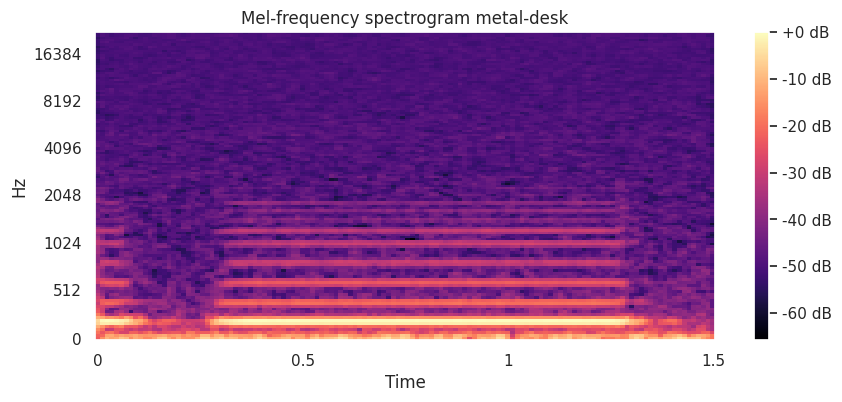

In [1391]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(Dataset_melspec[600,0], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
title = 'Mel-frequency spectrogram metal-desk'
plt.title(title)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# plt.tight_layout()
title
plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
plt.show()

In [1348]:
!pip install pdffonts

ERROR: Could not find a version that satisfies the requirement pdffonts (from versions: none)
ERROR: No matching distribution found for pdffonts


### データ分割

In [979]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.6
)



In [980]:
# テンソルに変換
Dataset_melspec_tensor = torch.tensor(Dataset_melspec, dtype=torch.float32)
Dataset_label_tensor = torch.tensor(Dataset_label_np, dtype=torch.int64)

# split (stratify by the first column of labels as an example)
train_feature_all, eval_feature_all, train_labels_all, eval_labels_all = train_test_split(
    Dataset_melspec_tensor, Dataset_label_tensor, 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.8
)

val_feature_all, test_feature_all, val_labels_all, test_labels_all = train_test_split(
    eval_feature_all, eval_labels_all, 
    stratify=eval_labels_all[:, 0], shuffle=True, random_state=0, train_size=0.2
)


test_feature_all = eval_feature_all
test_labels_all = eval_labels_all

print(train_labels_all.shape,test_labels_all.shape)


torch.Size([840, 3]) torch.Size([210, 3])


In [981]:
# 学習データにない物体の評価用データセットの作成
def Make_other_dataset(num):

    start = num*trials
    end = (num+1)*trials

    #テストデータの抽出
    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]

    #テストデータ以外でデータセットを作成
    other_feature = torch.cat((Dataset_melspec_tensor[:start,:,:,:],Dataset_melspec_tensor[end:,:,:,:]),dim=0)
    other_labels = torch.cat((Dataset_label_tensor[:start,:],Dataset_label_tensor[end:,:]),dim=0)

    #trainとvalに分割
    train_feature, val_feature, train_labels, val_labels = train_test_split(
        other_feature, other_labels, 
    stratify=other_labels[:, 0], shuffle=True, random_state=0, train_size=0.8
    )   
    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels

# 使用
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

In [982]:
def Alldataset():
    train_feature=train_feature_all
    train_labels=train_labels_all
    val_feature=val_feature_all
    val_labels=val_labels_all
    test_feature=test_feature_all
    test_labels=test_labels_all

    return train_feature,train_labels, val_feature, val_labels,test_feature,test_labels


# 評価

## t-SNEで特徴量空間の可視化

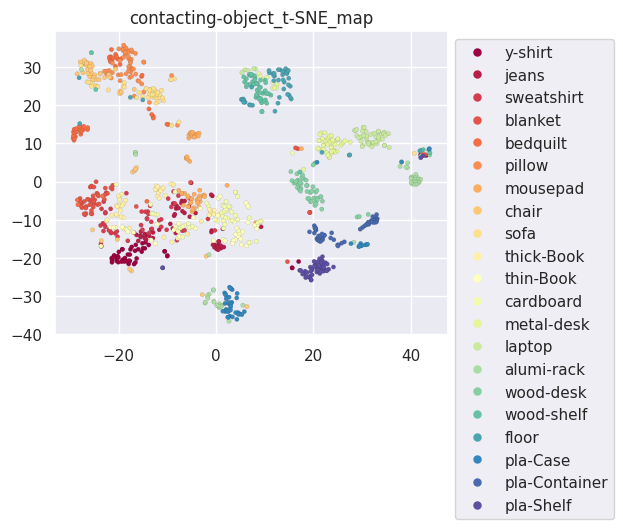

In [983]:


tsne = TSNE(
    n_components=2,
    perplexity=30.0,
    random_state=(0)
)
X_tsne = tsne.fit_transform(Dataset_mfcc.iloc[:,1:num_feature])

# プロット
title = "contacting-object_t-SNE_map"
plt.title(title)

scatter=plt.scatter(
            X_tsne[:, 0], 
            X_tsne[:, 1], 
            c=Dataset_mfcc['objNum'], 
            cmap='Spectral',
            edgecolor='black',
            linewidths=0.05,
            s=10 
        )  
# 凡例を追加
plt.legend(handles=scatter.legend_elements(num=21)[0],labels=objLabel,bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()

# plt.savefig("data/output_data/"+title+".pdf")

## SVMでの評価

In [984]:
def Eval_svm(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 10 #分割数
    stratifiedkfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0) #10分割交差検証のパラメータ定義

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)


In [985]:
def Eval_svm_LOOO(subject,trainDataset,labelDataset,target,save):
    #機械学習アルゴリズムの選択
    model = svm.SVC(kernel="linear",C =0.01,random_state = 0) 

    #10分割交差検証
    folds = 21 #分割数
    stratifiedkfold = KFold(n_splits=folds, shuffle=False)

    pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
    
    #classification_reportの作成
    report = classification_report(labelDataset, pred,digits=3,target_names=target)
    print(report)
    
    #混同行列の作成
    cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
    p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                    label=target,
                    xticklabels=target,
                    yticklabels=target)
    title = "confusion_matrix_"+subject
    plt.title(title)
    plt.xlabel('predict')
    plt.ylabel('actual')

    #保存設定
    if save == True:
        plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
        with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
            print(report)

### object層

In [986]:
# Eval_svm(
#     "object",
#     Dataset_mfcc.iloc[:,1:num_feature],
#     Dataset_mfcc.obj,
#     objLabel,
#     False
#     )

               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000      50.0
   sweatshirt      0.000     0.000     0.000      50.0
      blanket      0.000     0.000     0.000      50.0
     bedquilt      0.000     0.000     0.000      50.0
       pillow      0.000     0.000     0.000      50.0
     mousepad      0.000     0.000     0.000      50.0
        chair      0.000     0.000     0.000      50.0
         sofa      0.000     0.000     0.000      50.0
   thick-Book      0.000     0.000     0.000      50.0
    thin-Book      0.000     0.000     0.000      50.0
    cardboard      0.000     0.000     0.000      50.0
   metal-desk      0.000     0.000     0.000      50.0
       laptop      0.000     0.000     0.000      50.0
   alumi-rack      0.000     0.000     0.000      50.0
    wood-desk      0.000     0.000     0.000      50.0
   wood-shelf      0.000     0.000     0.000      50.0
        f

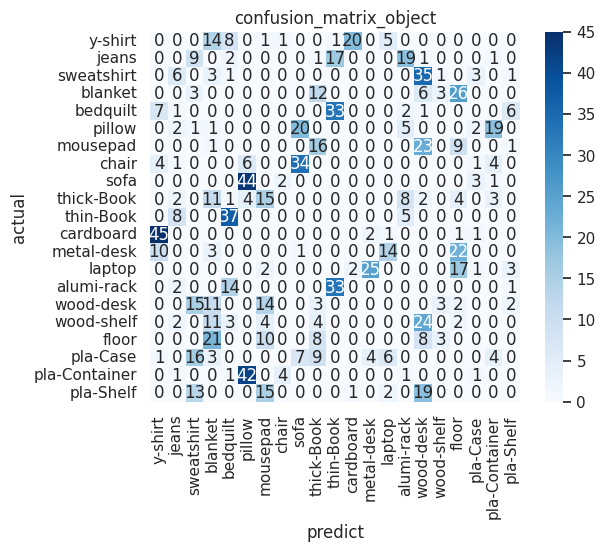

In [987]:
Eval_svm_LOOO(
    "object",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.obj,
    objLabel,
    False
    )

In [988]:
print( Dataset_mfcc.obj)

0         y-shirt
1         y-shirt
2         y-shirt
3         y-shirt
4         y-shirt
          ...    
1045    pla-Shelf
1046    pla-Shelf
1047    pla-Shelf
1048    pla-Shelf
1049    pla-Shelf
Name: obj, Length: 1050, dtype: object


### material層

              precision    recall  f1-score   support

    clothing      0.808     0.840     0.824       150
     bedding      0.787     0.887     0.834       150
 memory-foam      0.784     0.653     0.713       150
       paper      0.943     0.880     0.910       150
       metal      0.800     0.853     0.826       150
        wood      0.929     0.960     0.944       150
     plastic      0.910     0.880     0.895       150

    accuracy                          0.850      1050
   macro avg      0.852     0.850     0.849      1050
weighted avg      0.852     0.850     0.849      1050



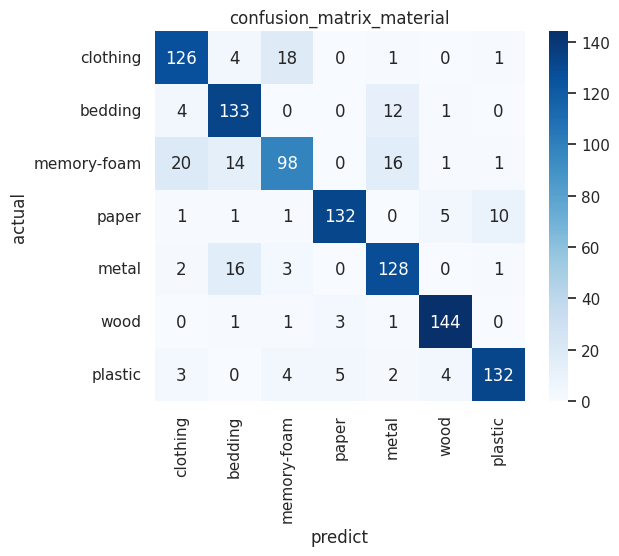

In [989]:
Eval_svm(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

              precision    recall  f1-score   support

    clothing      0.209     0.193     0.201       150
     bedding      0.314     0.467     0.375       150
 memory-foam      0.110     0.113     0.112       150
       paper      0.400     0.333     0.364       150
       metal      0.381     0.500     0.432       150
        wood      0.460     0.267     0.338       150
     plastic      0.520     0.433     0.473       150

    accuracy                          0.330      1050
   macro avg      0.342     0.330     0.328      1050
weighted avg      0.342     0.330     0.328      1050



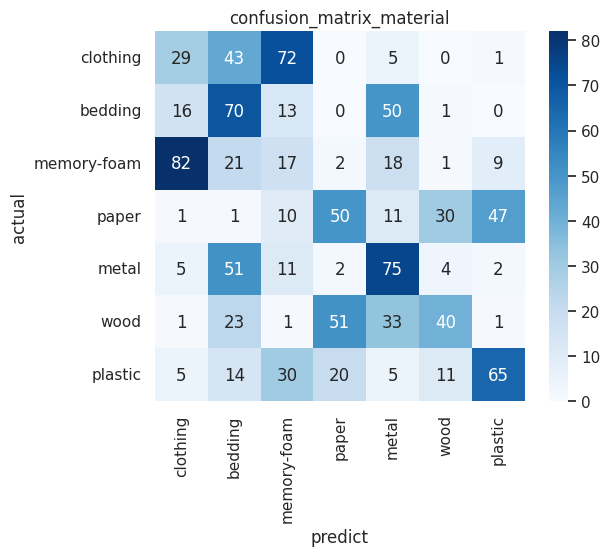

In [990]:
Eval_svm_LOOO(
    "material",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.mat,
    matLabel,
    False
    )

### soft-hard層

              precision    recall  f1-score   support

        soft      0.895     0.897     0.896       600
        hard      0.862     0.860     0.861       450

    accuracy                          0.881      1050
   macro avg      0.879     0.878     0.878      1050
weighted avg      0.881     0.881     0.881      1050



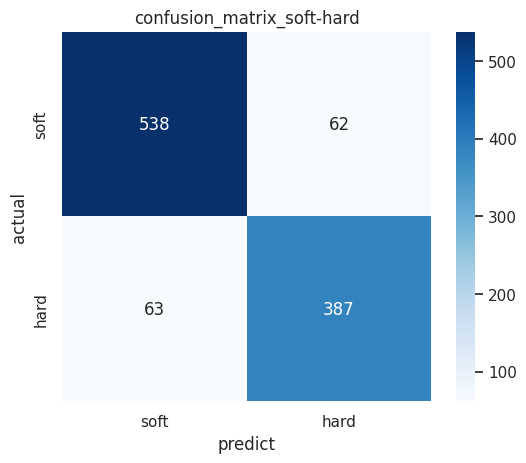

In [991]:
Eval_svm(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

              precision    recall  f1-score   support

        soft      0.836     0.835     0.836       600
        hard      0.780     0.782     0.781       450

    accuracy                          0.812      1050
   macro avg      0.808     0.809     0.809      1050
weighted avg      0.812     0.812     0.812      1050



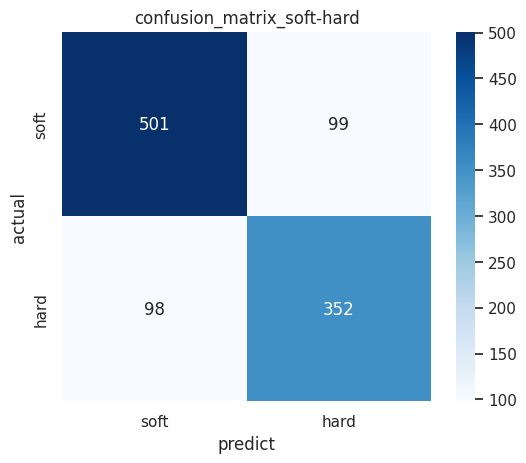

In [992]:
Eval_svm_LOOO(
    "soft-hard",
    Dataset_mfcc.iloc[:,1:num_feature],
    Dataset_mfcc.sh,
    shLabel,
    False
    )

### 提案手法適用時の評価

In [1321]:
# svm提案手法評価用
# split (stratify by the first column of labels as an example)
train_data_mfcc = []
train_label_mfcc = []
eval_data_mfcc = []
eval_label_mfcc = []

train_data_mfcc, eval_data_mfcc, train_label_mfcc, eval_label_mfcc = train_test_split(
    Dataset_mfcc.iloc[:,1:num_feature], Dataset_mfcc.iloc[:,40:43], 
    stratify=Dataset_label_np[:, 0], shuffle=True, random_state=0, train_size=0.8
)


In [1322]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.objNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
# Dec = model.predict_proba(eval_data_mfcc)
Dec = model.decision_function(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = objLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.objNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(210, 21)
210


,y-shirt,jeans,sweatshirt,blanket,bedquilt,pillow,mousepad,chair,sofa,thick-Book,thin-Book,cardboard,metal-desk,laptop,alumi-rack,wood-desk,wood-shelf,floor,pla-Case,pla-Container,pla-Shelf,decision,prediction,Actual
0,7.698299,13.307508,4.684668,7.711129,9.727024,15.281999,16.322609,9.713990,15.319426,8.713292,5.700069,11.290296,18.319850,4.692152,1.686658,16.290148,20.320247,19.322930,-0.320857,0.682155,2.677450,20.320247,16,17
1,14.304211,15.314372,19.320162,20.319944,16.316930,8.701925,14.309080,11.301595,10.221805,17.316183,12.289894,17.315854,4.692337,2.684558,3.688417,3.684026,5.704958,4.695566,0.677919,-0.323582,7.693717,20.319944,3,4
2,3.682341,12.318687,5.693525,5.686282,12.166033,13.165699,17.324823,11.905796,15.317675,11.305501,6.695000,10.264547,18.315264,13.210472,3.690722,6.719756,20.323804,19.323022,-0.325701,0.680110,2.675202,20.323804,16,16
3,10.306899,9.310039,10.294451,10.292573,20.325412,18.317386,13.318069,17.318389,19.322007,13.309689,4.681172,6.762440,5.708638,11.701117,4.712478,1.676296,16.310784,14.306853,0.675121,-0.327522,2.675944,20.325412,4,17
4,2.674874,11.310994,6.684200,3.679817,10.830539,13.292011,15.323995,8.705440,15.321927,12.317874,7.695283,11.306507,18.323823,16.307620,4.684490,7.712444,19.324972,20.326769,-0.327115,3.683727,0.672708,20.326769,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,14.308393,16.315338,20.320195,18.313811,12.284194,4.683642,15.312063,11.298961,7.702856,14.314549,18.317221,17.316797,4.691443,1.684655,7.706455,3.684793,5.690960,3.688591,1.682161,0.681130,9.733427,20.320195,2,2
206,12.314548,10.316078,11.308490,3.683748,18.323928,20.323246,10.263135,19.326482,17.319774,13.324051,7.690957,5.685770,2.681222,14.159211,16.319034,-0.327866,14.192892,6.695943,3.685159,0.672930,2.674944,20.323246,5,5
207,14.301153,16.314629,19.321397,20.320971,16.313293,9.704040,10.290432,13.308532,11.208570,18.319911,11.291107,16.313712,4.686597,2.685247,4.692944,3.683754,5.696727,3.685383,0.680488,-0.323480,7.701112,20.320971,3,3
208,14.310870,18.317854,20.322262,18.315315,13.307518,7.687244,13.310622,11.305229,8.715257,17.318820,14.314722,17.317723,4.682681,0.683488,6.709608,2.680711,4.687012,3.682939,0.679760,1.679358,9.752491,20.322262,2,2


In [1323]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object


平均 decision: 20.310989387128892
              precision    recall  f1-score   support

           0      1.000     0.800     0.889        10
           1      0.643     0.900     0.750        10
           2      0.556     0.556     0.556         9
           3      0.909     1.000     0.952        10
           4      0.800     0.800     0.800        10
           5      0.700     0.700     0.700        10
           6      0.889     0.889     0.889         9
           7      0.714     0.556     0.625         9
           8      0.692     0.900     0.783        10
           9      1.000     0.900     0.947        10
          10      0.875     0.700     0.778        10
          11      0.636     0.700     0.667        10
          12      1.000     0.800     0.889        10
          13      1.000     0.889     0.941         9
          14      0.818     0.900     0.857        10
          15      1.000     1.000     1.000        10
          16      0.818     0.900     0.857      

In [1324]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.matNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
# Dec = model.predict_proba(eval_data_mfcc)
Dec = model.decision_function(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = matLabel)

df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.matNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(210, 7)
210


,clothing,bedding,memory-foam,paper,metal,wood,plastic,decision,prediction,Actual
0,1.706911,4.254341,5.302711,0.693580,3.273191,6.313527,-0.312249,6.313527,5,5
1,5.283975,6.300234,3.267899,4.278587,0.717974,1.750358,-0.313165,6.300234,1,1
2,0.733560,2.816338,5.308220,1.726648,4.260492,6.310884,-0.317408,6.310884,5,5
3,2.181981,6.311763,5.312596,0.724144,2.847113,4.010414,-0.320569,6.311763,1,5
4,0.692693,1.738841,4.308185,3.114755,5.299414,6.316642,-0.320587,6.316642,5,5
...,...,...,...,...,...,...,...,...,...,...
205,6.290743,4.229564,3.228418,5.293771,1.731670,0.720570,-0.301063,6.290743,0,0
206,3.266307,6.296827,5.310613,2.206355,4.279673,-0.310083,0.683107,6.296827,1,1
207,5.284148,6.299019,3.256767,4.278934,0.719798,1.734886,-0.310830,6.299019,1,1
208,6.300957,4.255156,3.258366,5.301652,1.710182,0.702061,-0.304219,6.300957,0,0


In [1325]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)


平均 decision: 6.299241835322413
              precision    recall  f1-score   support

           2      0.000     0.000     0.000         1
           3      0.000     0.000     0.000         0
           4      1.000     1.000     1.000         1

    accuracy                          0.500         2
   macro avg      0.333     0.333     0.333         2
weighted avg      0.500     0.500     0.500         2

採用数: 2
採用率: 0.009523809523809525
不採用: (2, 10)


In [1302]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec)

df = pd.DataFrame(Dec,columns = shLabel)
print(df)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

[[6.09274898e-02 9.39072510e-01]
 [9.06165035e-01 9.38349654e-02]
 [1.16663188e-01 8.83336812e-01]
 [9.92595168e-01 7.40483249e-03]
 [1.18071428e-02 9.88192857e-01]
 [2.61699923e-03 9.97383001e-01]
 [7.58147323e-03 9.92418527e-01]
 [4.07389036e-07 9.99999593e-01]
 [8.69687973e-01 1.30312027e-01]
 [2.78884823e-10 1.00000000e+00]
 [6.29050251e-01 3.70949749e-01]
 [7.44743822e-03 9.92552562e-01]
 [2.10667470e-06 9.99997893e-01]
 [1.37778937e-01 8.62221063e-01]
 [1.63932146e-01 8.36067854e-01]
 [9.36446332e-02 9.06355367e-01]
 [3.77797058e-03 9.96222029e-01]
 [1.82173415e-07 9.99999818e-01]
 [5.26997013e-01 4.73002987e-01]
 [4.62352913e-01 5.37647087e-01]
 [9.97054836e-01 2.94516448e-03]
 [8.13416100e-01 1.86583900e-01]
 [2.53128734e-01 7.46871266e-01]
 [1.60932641e-02 9.83906736e-01]
 [3.37618828e-01 6.62381172e-01]
 [9.39353556e-01 6.06464437e-02]
 [9.37954121e-01 6.20458788e-02]
 [1.24985991e-01 8.75014009e-01]
 [1.21383702e-01 8.78616298e-01]
 [9.85920442e-01 1.40795577e-02]
 [4.617700

,soft,hard,decision,prediction,Actual
0,6.092749e-02,0.939073,0.939073,1,1
1,9.061650e-01,0.093835,0.906165,0,0
2,1.166632e-01,0.883337,0.883337,1,1
3,9.925952e-01,0.007405,0.992595,0,1
4,1.180714e-02,0.988193,0.988193,1,1
...,...,...,...,...,...
205,7.244311e-01,0.275569,0.724431,0,0
206,9.919703e-01,0.008030,0.991970,0,0
207,7.469676e-01,0.253032,0.746968,0,0
208,9.250885e-01,0.074912,0.925088,0,0


In [1303]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
print(df)
print(classification_report(df['Actual'], df['prediction'],digits=3))

Up_softhard = df[df['decision'] >= average_decision_softhard]

print(Up_softhard.shape)
print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)


平均 decision: 0.8917054693864139
             soft      hard  decision  prediction  Actual
5    2.616999e-03  0.997383  0.997383           1       1
8    8.696880e-01  0.130312  0.869688           0       0
10   6.290503e-01  0.370950  0.629050           0       1
13   1.377789e-01  0.862221  0.862221           1       1
18   5.269970e-01  0.473003  0.526997           0       0
21   8.134161e-01  0.186584  0.813416           0       0
25   9.393536e-01  0.060646  0.939354           0       0
26   9.379541e-01  0.062046  0.937954           0       0
29   9.859204e-01  0.014080  0.985920           0       0
34   6.997383e-01  0.300262  0.699738           0       0
35   3.210381e-01  0.678962  0.678962           1       0
36   4.762896e-01  0.523710  0.523710           1       0
38   9.628950e-01  0.037105  0.962895           0       0
43   1.859732e-01  0.814027  0.814027           1       0
48   5.581977e-01  0.441802  0.558198           0       0
51   6.128870e-01  0.387113  0.612887   

In [1304]:
# print(train_label_mfcc.objNum)
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 
model.fit(train_data_mfcc,train_label_mfcc.shNum)

#推定
pred = model.predict(eval_data_mfcc)

#推定確信度の算出
Dec = model.predict_proba(eval_data_mfcc)
print(Dec.shape)

df = pd.DataFrame(Dec,columns = shLabel)
df["decision"] = np.max(Dec, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(eval_label_mfcc.shNum)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df

(210, 2)
210


,soft,hard,decision,prediction,Actual
0,6.092749e-02,0.939073,0.939073,1,1
1,9.061650e-01,0.093835,0.906165,0,0
2,1.166632e-01,0.883337,0.883337,1,1
3,9.925952e-01,0.007405,0.992595,0,1
4,1.180714e-02,0.988193,0.988193,1,1
...,...,...,...,...,...
205,7.244311e-01,0.275569,0.724431,0,0
206,9.919703e-01,0.008030,0.991970,0,0
207,7.469676e-01,0.253032,0.746968,0,0
208,9.250885e-01,0.074912,0.925088,0,0


In [1305]:

df = df.iloc[Down_softhard.index]


print(classification_report(df['Actual'], df['prediction'],digits=3))

              precision    recall  f1-score   support

           0      0.917     0.667     0.772        33
           1      0.522     0.857     0.649        14

    accuracy                          0.723        47
   macro avg      0.719     0.762     0.710        47
weighted avg      0.799     0.723     0.735        47



### 学習データにない物体の評価

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1426: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1426: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1426: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  w

[[0.         0.05577152 0.28520513 ... 0.01027615 0.00439979 0.02548359]
 [0.         0.42076157 0.19437712 ... 0.00876068 0.00348873 0.06388575]
 [0.         0.13650988 0.19171591 ... 0.02231848 0.00563737 0.03537169]
 ...
 [0.04998705 0.07249679 0.04285425 ... 0.08767718 0.09482084 0.        ]
 [0.13360449 0.08353443 0.04283112 ... 0.01288899 0.03392184 0.        ]
 [0.16600015 0.06709466 0.05670641 ... 0.01424352 0.03358082 0.        ]] (1050, 21)
               precision    recall  f1-score   support

      y-shirt      0.000     0.000     0.000      50.0
        jeans      0.000     0.000     0.000      50.0
   sweatshirt      0.000     0.000     0.000      50.0
      blanket      0.000     0.000     0.000      50.0
     bedquilt      0.000     0.000     0.000      50.0
       pillow      0.000     0.000     0.000      50.0
     mousepad      0.000     0.000     0.000      50.0
        chair      0.000     0.000     0.000      50.0
         sofa      0.000     0.000     0.000     

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1426: RuntimeWarning: Number of classes in training fold (20) does not match total number of classes (21). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


,y-shirt,jeans,sweatshirt,blanket,bedquilt,pillow,mousepad,chair,sofa,thick-Book,thin-Book,cardboard,metal-desk,laptop,alumi-rack,wood-desk,wood-shelf,floor,pla-Case,pla-Container,pla-Shelf,decision,prediction,Actual
0,0.000000,0.055772,0.285205,0.213496,0.123377,0.011831,0.015684,0.094304,0.019913,0.032080,0.027965,0.028392,0.004335,0.005129,0.025107,0.004476,0.006630,0.006145,0.010276,0.004400,0.025484,0.285205,2,0
1,0.000000,0.420762,0.194377,0.047473,0.025413,0.006932,0.020114,0.050227,0.009755,0.009942,0.086816,0.021929,0.002529,0.002136,0.015251,0.002781,0.003526,0.003902,0.008761,0.003489,0.063886,0.420762,1,0
2,0.000000,0.136510,0.191716,0.225622,0.065929,0.018976,0.027513,0.090739,0.030496,0.025004,0.040328,0.028729,0.005517,0.004650,0.023287,0.005593,0.007053,0.009009,0.022318,0.005637,0.035372,0.225622,1,0
3,0.000000,0.057003,0.203971,0.376678,0.076517,0.010908,0.014730,0.076065,0.015056,0.014149,0.027602,0.023010,0.004235,0.003690,0.015304,0.004397,0.005518,0.005423,0.014999,0.004229,0.046518,0.376678,3,0
4,0.000000,0.262701,0.283811,0.135342,0.051370,0.008414,0.025925,0.058906,0.012432,0.015607,0.048925,0.024228,0.002932,0.003231,0.015456,0.003286,0.005313,0.005773,0.009502,0.003401,0.023446,0.283811,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.052005,0.059913,0.034079,0.044930,0.005752,0.003542,0.038613,0.008458,0.004284,0.009829,0.528853,0.060487,0.004134,0.003369,0.012132,0.031401,0.004432,0.004184,0.024904,0.064699,0.000000,0.528853,10,20
1046,0.042472,0.067205,0.031861,0.030108,0.006007,0.003895,0.039602,0.008530,0.004547,0.011784,0.499051,0.066631,0.004691,0.003698,0.012577,0.026696,0.004702,0.004444,0.030175,0.101326,0.000000,0.499051,10,20
1047,0.049987,0.072497,0.042854,0.029422,0.006800,0.004719,0.033147,0.011804,0.005197,0.013999,0.414862,0.065087,0.005313,0.004706,0.022527,0.024508,0.005267,0.004807,0.087677,0.094821,0.000000,0.414862,10,20
1048,0.133604,0.083534,0.042831,0.087161,0.007001,0.004494,0.057725,0.008637,0.005935,0.010058,0.311123,0.148437,0.005038,0.003376,0.010084,0.023529,0.005212,0.005409,0.012889,0.033922,0.000000,0.311123,10,20


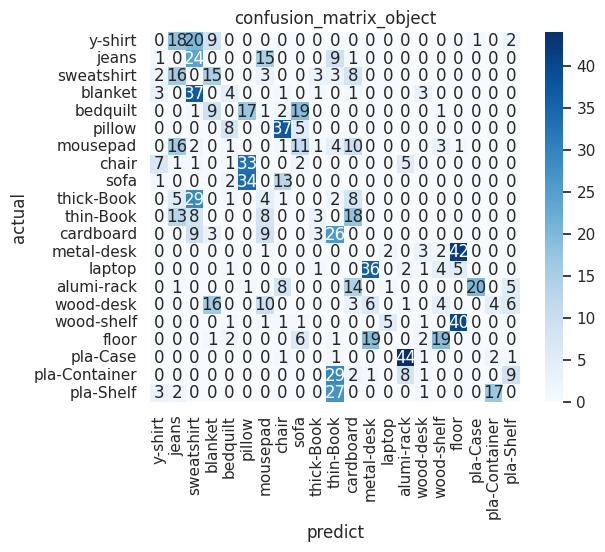

In [1306]:
subject = "object"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.objNum
target = objLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df





In [1307]:
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
# filtered_rows = df[df['prediction'] == df['Actual']]

# print(filtered_rows)

# average_decision_object = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
Up_object = df[df['decision'] >= average_decision_object]


print(classification_report(Up_object['Actual'], Up_object['prediction'],digits=3))

print("採用数:", len(Up_object.index))
print("採用率:", len(Up_object.index)/len_df)
# 閾値未満を抽出しDFを作成
Down_object = df[df['decision'] < average_decision_object]

print("不採用数:",Down_object.shape)
# Down_object

平均 decision: 0.6199860068242813
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       1.0
           1      0.000     0.000     0.000       2.0
           2      0.000     0.000     0.000       2.0
           3      0.000     0.000     0.000      10.0
           4      0.000     0.000     0.000      19.0
           5      0.000     0.000     0.000      18.0
           6      0.000     0.000     0.000       1.0
           7      0.000     0.000     0.000       6.0
           8      0.000     0.000     0.000       7.0
           9      0.000     0.000     0.000       2.0
          10      0.000     0.000     0.000      11.0
          11      0.000     0.000     0.000       9.0
          12      0.000     0.000     0.000      26.0
          13      0.000     0.000     0.000      24.0
          14      0.000     0.000     0.000      10.0
          15      0.000     0.000     0.000       5.0
          16      0.000     0.000     0.000      

[[0.21606701 0.58452528 0.10235285 ... 0.01088607 0.00880907 0.02548388]
 [0.88643757 0.04090552 0.04098217 ... 0.00168678 0.0017194  0.01433173]
 [0.22569739 0.63302682 0.063998   ... 0.01096602 0.00621354 0.03285826]
 ...
 [0.45208289 0.01843392 0.01791548 ... 0.02359995 0.01459363 0.37078783]
 [0.90934229 0.00288233 0.01723695 ... 0.00174768 0.00572597 0.0134023 ]
 [0.92533454 0.0023002  0.00441688 ... 0.00105945 0.00256293 0.01508783]] (1050, 7)
              precision    recall  f1-score   support

    clothing      0.313     0.473     0.377       150
     bedding      0.207     0.187     0.196       150
 memory-foam      0.110     0.113     0.112       150
       paper      0.379     0.500     0.431       150
       metal      0.403     0.333     0.365       150
        wood      0.520     0.433     0.473       150
     plastic      0.460     0.267     0.338       150

    accuracy                          0.330      1050
   macro avg      0.342     0.330     0.327      1050
weig

,clothing,bedding,memory-foam,paper,metal,wood,plastic,decision,prediction,Actual
0,0.216067,0.584525,0.102353,0.051876,0.010886,0.008809,0.025484,0.584525,1,0
1,0.886438,0.040906,0.040982,0.013937,0.001687,0.001719,0.014332,0.886438,0,0
2,0.225697,0.633027,0.063998,0.027240,0.010966,0.006214,0.032858,0.633027,1,0
3,0.130237,0.811379,0.017047,0.011057,0.003825,0.003209,0.023247,0.811379,1,0
4,0.465036,0.350545,0.095935,0.051533,0.007411,0.005765,0.023774,0.465036,0,0
...,...,...,...,...,...,...,...,...,...,...
1045,0.886242,0.006888,0.011291,0.028726,0.004458,0.007070,0.055325,0.886242,0,6
1046,0.797911,0.010137,0.011233,0.051420,0.009192,0.008982,0.111126,0.797911,0,6
1047,0.452083,0.018434,0.017915,0.102586,0.023600,0.014594,0.370788,0.452083,0,6
1048,0.909342,0.002882,0.017237,0.049662,0.001748,0.005726,0.013402,0.909342,0,6


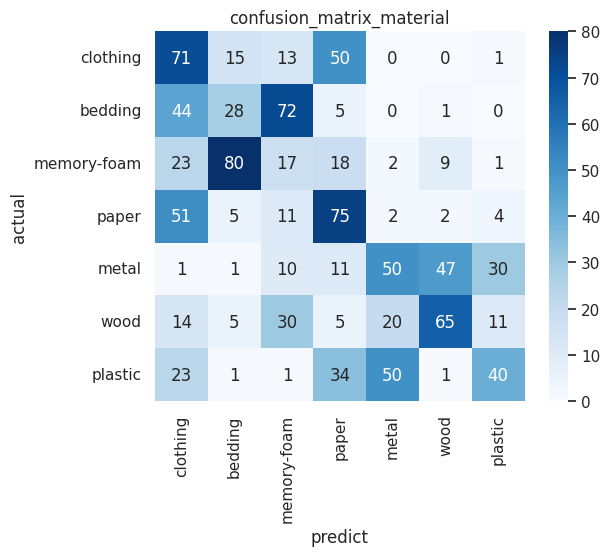

In [1308]:
subject = "material"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.matNum
target = matLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df


In [1309]:
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成


df = df.iloc[Down_object.index]
Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape)

              precision    recall  f1-score   support

           0      0.300     0.429     0.353        21
           1      0.125     0.091     0.105        33
           2      0.000     0.000     0.000        26
           3      0.205     0.667     0.314        12
           4      0.786     0.423     0.550        52
           5      0.647     0.733     0.688        30
           6      0.280     0.194     0.230        36

    accuracy                          0.338       210
   macro avg      0.335     0.362     0.320       210
weighted avg      0.396     0.338     0.344       210

採用数: 210
採用率: 0.2
不採用: (619, 10)


[[0.99227107 0.00772893]
 [0.99413151 0.00586849]
 [0.96544163 0.03455837]
 ...
 [0.11502138 0.88497862]
 [0.49299971 0.50700029]
 [0.54907467 0.45092533]] (1050, 2)
              precision    recall  f1-score   support

        soft      0.780     0.782     0.781       450
        hard      0.836     0.835     0.836       600

    accuracy                          0.812      1050
   macro avg      0.808     0.809     0.809      1050
weighted avg      0.812     0.812     0.812      1050

1050


,soft,hard,decision,prediction,Actual
0,0.992271,0.007729,0.992271,0,0
1,0.994132,0.005868,0.994132,0,0
2,0.965442,0.034558,0.965442,0,0
3,0.989129,0.010871,0.989129,0,0
4,0.956330,0.043670,0.956330,0,0
...,...,...,...,...,...
1045,0.369854,0.630146,0.630146,1,1
1046,0.293085,0.706915,0.706915,1,1
1047,0.115021,0.884979,0.884979,1,1
1048,0.493000,0.507000,0.507000,0,1


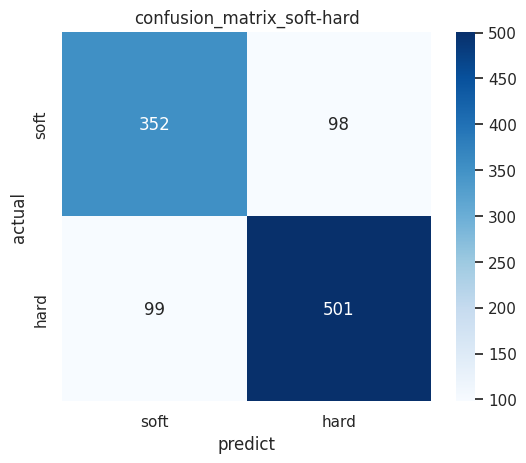

In [1310]:
subject = "soft-hard"
trainDataset = Dataset_mfcc.iloc[:,1:num_feature]
labelDataset = Dataset_mfcc.shNum
target = shLabel
save = False

#機械学習アルゴリズムの選択
model = svm.SVC(kernel="linear",C =0.01,random_state = 0,probability=True) 

#10分割交差検証
folds = 21 #分割数
stratifiedkfold = KFold(n_splits=folds, shuffle=False)

pred = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold)
proba = cross_val_predict(model, trainDataset,labelDataset, cv=stratifiedkfold,method='predict_proba')
print(proba,proba.shape)
#classification_reportの作成
report = classification_report(labelDataset, pred,digits=3,target_names=target)
print(report)

#混同行列の作成
cm = confusion_matrix(y_true=labelDataset,y_pred=pred)
p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                label=target,
                xticklabels=target,
                yticklabels=target)
title = "confusion_matrix_"+subject
plt.title(title)
plt.xlabel('predict')
plt.ylabel('actual')

#保存設定
if save == True:
    plt.savefig('data/output_data/'+title+'.pdf', bbox_inches='tight')
    with open('data/output_data/eval_report_'+subject+'.pdf','w') as f:
        print(report)


df = pd.DataFrame(proba,columns = target)
df["decision"] = np.max(proba, axis=1)
df["prediction"] = pred
df['Actual'] = np.array(labelDataset)

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)


len_df = len(df.index)
print(len_df)
df



In [1311]:
df = df.iloc[Down_material.index]
print(df)
print(classification_report(df['Actual'], df['prediction'],digits=3))

Up_softhard = df[df['decision'] >= average_decision_softhard]

print(Up_softhard.shape)
print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape)

          soft      hard  decision  prediction  Actual
0     0.992271  0.007729  0.992271           0       0
2     0.965442  0.034558  0.965442           0       0
4     0.956330  0.043670  0.956330           0       0
5     0.982649  0.017351  0.982649           0       0
6     0.963400  0.036600  0.963400           0       0
...        ...       ...       ...         ...     ...
1041  0.548728  0.451272  0.548728           0       1
1042  0.302733  0.697267  0.697267           1       1
1043  0.517393  0.482607  0.517393           0       1
1044  0.338247  0.661753  0.661753           1       1
1047  0.115021  0.884979  0.884979           1       1

[619 rows x 5 columns]
              precision    recall  f1-score   support

           0      0.747     0.711     0.728       304
           1      0.733     0.768     0.750       315

    accuracy                          0.740       619
   macro avg      0.740     0.739     0.739       619
weighted avg      0.740     0.740     0.740 

### メルスペクトログラムでSVM評価

               precision    recall  f1-score   support

      y-shirt      1.000     0.900     0.947        50
        jeans      0.849     0.900     0.874        50
   sweatshirt      0.882     0.900     0.891        50
      blanket      0.769     0.800     0.784        50
     bedquilt      0.788     0.820     0.804        50
       pillow      0.891     0.820     0.854        50
     mousepad      0.849     0.900     0.874        50
        chair      1.000     0.920     0.958        50
         sofa      0.863     0.880     0.871        50
   thick-Book      0.868     0.920     0.893        50
    thin-Book      0.830     0.880     0.854        50
    cardboard      0.979     0.920     0.948        50
   metal-desk      1.000     1.000     1.000        50
       laptop      0.941     0.960     0.950        50
   alumi-rack      0.953     0.820     0.882        50
    wood-desk      0.786     0.880     0.830        50
   wood-shelf      0.925     0.980     0.951        50
        f

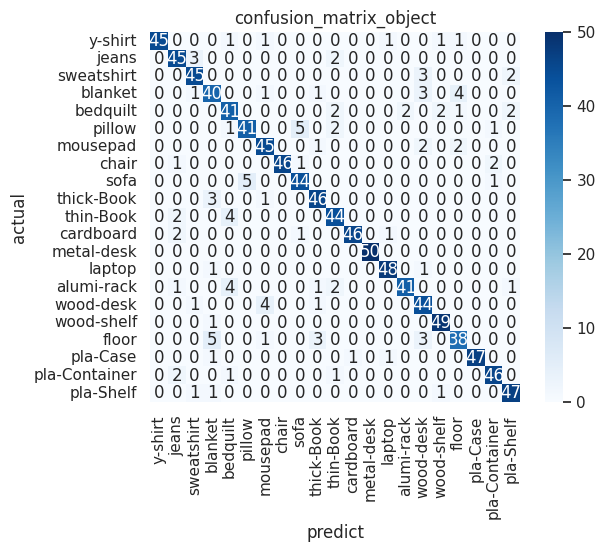

In [1002]:
Eval_svm(
    "object",
    Dataset_melspec_svm,
    Dataset_mfcc.obj,
    objLabel,
    False
    )

              precision    recall  f1-score   support

    clothing      0.903     0.927     0.914       150
     bedding      0.889     0.960     0.923       150
 memory-foam      0.918     0.820     0.866       150
       paper      0.945     0.913     0.929       150
       metal      0.851     0.913     0.881       150
        wood      0.967     0.980     0.974       150
     plastic      0.958     0.907     0.932       150

    accuracy                          0.917      1050
   macro avg      0.919     0.917     0.917      1050
weighted avg      0.919     0.917     0.917      1050



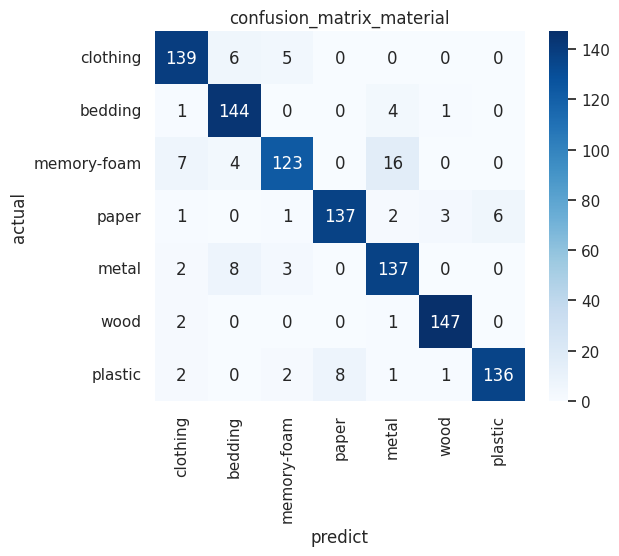

In [1003]:
Eval_svm(
    "material",
    Dataset_melspec_svm,
    Dataset_mfcc.mat,
    matLabel,
    False
    )

              precision    recall  f1-score   support

        soft      0.970     0.960     0.965       600
        hard      0.947     0.960     0.954       450

    accuracy                          0.960      1050
   macro avg      0.959     0.960     0.959      1050
weighted avg      0.960     0.960     0.960      1050



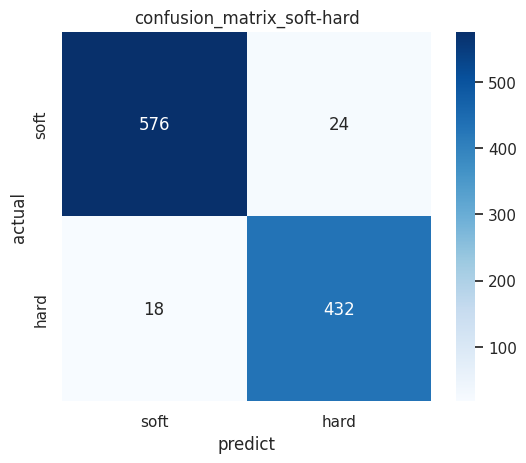

In [1004]:
Eval_svm(
    "soft-hard",
    Dataset_melspec_svm,
    Dataset_mfcc.sh,
    shLabel,
    False
    )

## CNNでの評価

In [1005]:
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)

### モデルの保存関数

In [1006]:
def Time():
    # 日本時間のタイムゾーンを取得
    jst = pytz.timezone('Asia/Tokyo')
    # 現在の日本時間を取得
    now = datetime.now(jst)
    # 時刻を指定された形式の文字列に変換
    time = now.strftime("%Y%m%d%H%M")

    return time

In [1007]:
def SaveModel(model,modelname):
    time = Time()
    model_path = 'data/models_saved/'+time+"_"+modelname+'.pth'
    torch.save(model, model_path)

# #読み込み用
# model_path = 'data/models_saved/202406302329_shModel_2.pth'
# xModel = torch.load(model_path)

### 評価関数

In [1367]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN(data_loader,device,num_label,num_trial):
    with torch.no_grad():
        if num_label == 0:
            model = shModel_trained
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            model = matModel_trained
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            model = objModel_trained
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            print(y[0].shape)
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "Confusion_matrix_"+model_name
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        plt.title(title)
        plt.xlabel('Predict')
        plt.ylabel('Actual')
        plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

In [1375]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN_trained(data_loader,device,num_label,num_trial,model):
    with torch.no_grad():
        if num_label == 0:
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            print(y)
            confidence = y[0]
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        #混同行列の作成
        cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
                        xticklabels=label,
                        yticklabels=label)
        title = "Confusion_matrix_"+model_name
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42
        plt.title(title)
        plt.xlabel('Predict')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig('data/output_data/'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

### soft-hard 1

In [1010]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [1011]:
# モデルのインポート・構築

from models.dymn.model import get_model as get_dymn
shModel = get_dymn(pretrained_name="dymn10_as")

#パラメータを固定
for param in shModel.parameters():
    param.requires_grad = True

#classifierのネットワーク構造を変更・パラメータの更新を許可
shModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.Linear(in_features=527, out_features=2, bias=True),  # 新しい層
)
print(shModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

/opt/conda/lib/python3.10/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


cuda:0
Epoch [1/100], Train Loss: 0.8728, Validation Loss: 24.0034
Epoch [2/100], Train Loss: 0.7094, Validation Loss: 43.7715
Epoch [3/100], Train Loss: 0.3527, Validation Loss: 23.5645
Epoch [4/100], Train Loss: 0.1419, Validation Loss: 13.4261
Epoch [5/100], Train Loss: 0.0787, Validation Loss: 7.2943
Epoch [6/100], Train Loss: 0.0250, Validation Loss: 4.0753
Epoch [7/100], Train Loss: 0.0055, Validation Loss: 2.4549
Epoch [8/100], Train Loss: 0.0014, Validation Loss: 1.6987
Epoch [9/100], Train Loss: 0.0015, Validation Loss: 1.0684
Epoch [10/100], Train Loss: 0.0007, Validation Loss: 0.6894
Epoch [11/100], Train Loss: 0.0006, Validation Loss: 0.4655
Epoch [12/100], Train Loss: 0.0004, Validation Loss: 0.3380
Epoch [13/100], Train Loss: 0.0003, Validation Loss: 0.2481
Epoch [14/100], Train Loss: 0.0002, Validation Loss: 0.1797
Epoch [15/100], Train Loss: 0.0002, Validation Loss: 0.1422
Epoch [16/100], Train Loss: 0.0002, Validation Loss: 0.1172
Epoch [17/100], Train Loss: 0.0003, Va

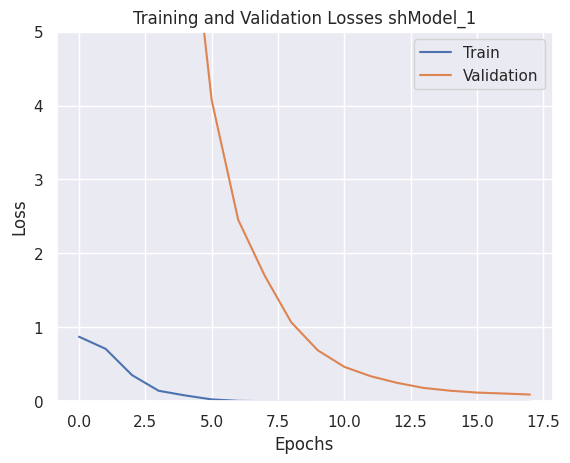

torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([10, 2])
              precision    recall  f1-score   support

        soft      0.887     0.956     0.920        90
        hard      0.965     0.908     0.936       120

    accuracy                          0.929       210
   macro avg      0.926     0.932     0.928       210
weighted avg      0.931     0.929     0.929       210



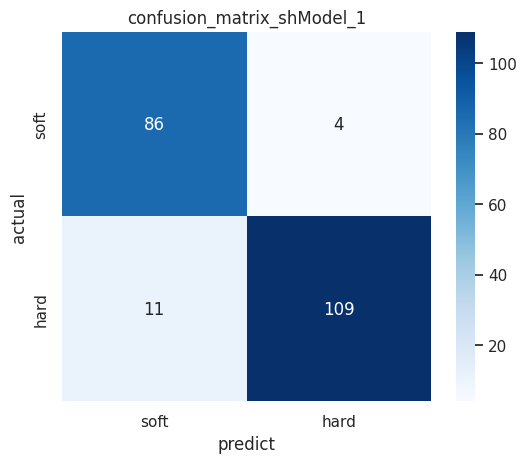

In [1012]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net1 = shModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net1.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.1) and epoch<max_epoch:
    # 訓練データでの学習
    net1.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net1(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net1.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net1(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_1'    
shModel_trained = net1
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,0,1)

print(report)


In [1013]:
print(confidences)

[array([-4.3677063,  3.998333 ], dtype=float32), array([ 6.72844  , -6.2290716], dtype=float32), array([-7.186025 ,  6.3215857], dtype=float32), array([ 8.423815, -7.730961], dtype=float32), array([-6.2467494,  5.419937 ], dtype=float32), array([-10.974836,   9.674092], dtype=float32), array([-10.459938,   9.50117 ], dtype=float32), array([-2.3366492,  1.8647726], dtype=float32), array([ 12.310661, -11.34184 ], dtype=float32), array([-8.644682,  7.568718], dtype=float32), array([-8.021791,  7.31013 ], dtype=float32), array([-8.998205 ,  7.8886504], dtype=float32), array([-6.3998213,  5.539541 ], dtype=float32), array([-8.599319 ,  7.6081486], dtype=float32), array([-6.8936353,  6.2141924], dtype=float32), array([-6.656257,  6.321546], dtype=float32), array([-11.488693,  10.290949], dtype=float32), array([-13.700979,  12.52092 ], dtype=float32), array([ 9.071409, -8.214903], dtype=float32), array([-13.265913,  11.794695], dtype=float32), array([10.960592, -9.770114], dtype=float32), arr

### material 1

In [1014]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-23.8109, -19.7109, -13.1839,  ...,  -9.4136,  -9.8433, -12.7758],
          [-23.4827, -22.4204, -17.0588,  ..., -12.2277, -16.7844, -18.6201],
          [-26.5524, -25.9204, -29.1905,  ..., -25.2004, -24.9043, -29.6452],
          ...,
          [-55.7133, -52.6507, -51.8638,  ..., -52.6737, -52.4706, -54.1325],
          [-54.7137, -52.7646, -53.4942,  ..., -52.9719, -52.9461, -54.0942],
          [-55.0564, -51.4011, -52.1685,  ..., -52.1697, -51.5944, -54.3381]]],


        [[[-15.1125,  -5.9229,  -5.4663,  ...,  -6.5937, -11.8480, -10.7284],
          [-12.9873,  -7.5467, -10.0635,  ...,  -6.1333, -10.9136,  -9.3855],
          [-17.1038, -15.6422, -15.8783,  ..., -14.8341, -14.2252, -13.5668],
          ...,
          [-49.8661, -49.7012, -50.2227,  ..., -50.3835, -49.8694, -50.7761],
          [-52.2558, -50.1145, -49.4021,  ..., -51.2810, -49.7634, -50.8934],
          [-54.6858, -51.1991, -49.0457,  ..., -49.6776, -49.2134, -50.9535]]],


        [[[-21.2450, -11.

In [1015]:
# モデルのインポート・構築

matModel = shModel_trained

#パラメータの更新を許可
for param in matModel.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=7, bias=True),  # 新しい層
)
print(matModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

cuda:0
Epoch [1/200], Train Loss: 1.9457, Validation Loss: 1.9420
Epoch [2/200], Train Loss: 1.9401, Validation Loss: 1.9369
Epoch [3/200], Train Loss: 1.9343, Validation Loss: 1.9309
Epoch [4/200], Train Loss: 1.9267, Validation Loss: 1.9231
Epoch [5/200], Train Loss: 1.9165, Validation Loss: 1.9124
Epoch [6/200], Train Loss: 1.9021, Validation Loss: 1.8971
Epoch [7/200], Train Loss: 1.8811, Validation Loss: 1.8744
Epoch [8/200], Train Loss: 1.8503, Validation Loss: 1.8401
Epoch [9/200], Train Loss: 1.8037, Validation Loss: 1.7888
Epoch [10/200], Train Loss: 1.7364, Validation Loss: 1.7172
Epoch [11/200], Train Loss: 1.6498, Validation Loss: 1.6301
Epoch [12/200], Train Loss: 1.5559, Validation Loss: 1.5421
Epoch [13/200], Train Loss: 1.4702, Validation Loss: 1.4670
Epoch [14/200], Train Loss: 1.4016, Validation Loss: 1.4083
Epoch [15/200], Train Loss: 1.3509, Validation Loss: 1.3626
Epoch [16/200], Train Loss: 1.3127, Validation Loss: 1.3257
Epoch [17/200], Train Loss: 1.2812, Valida

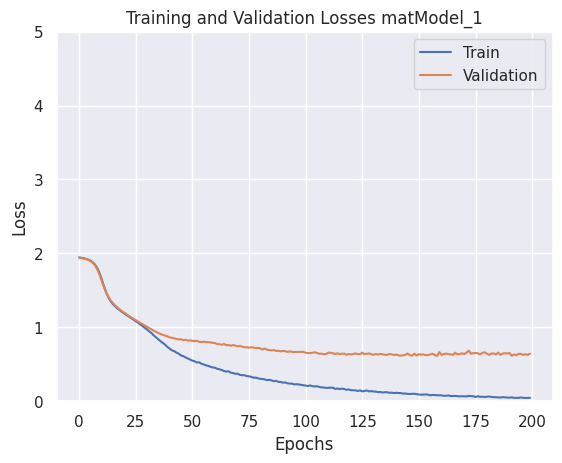

torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([10, 7])
              precision    recall  f1-score   support

    clothing      0.711     0.900     0.794        30
     bedding      0.852     0.767     0.807        30
 memory-foam      0.731     0.633     0.679        30
       paper      0.815     0.733     0.772        30
       metal      0.870     0.667     0.755        30
        wood      0.730     0.900     0.806        30
     plastic      0.875     0.933     0.903        30

    accuracy                          0.790       210
   macro avg      0.797     0.790     0.788       210
weighted avg      0.797     0.790     0.788       210



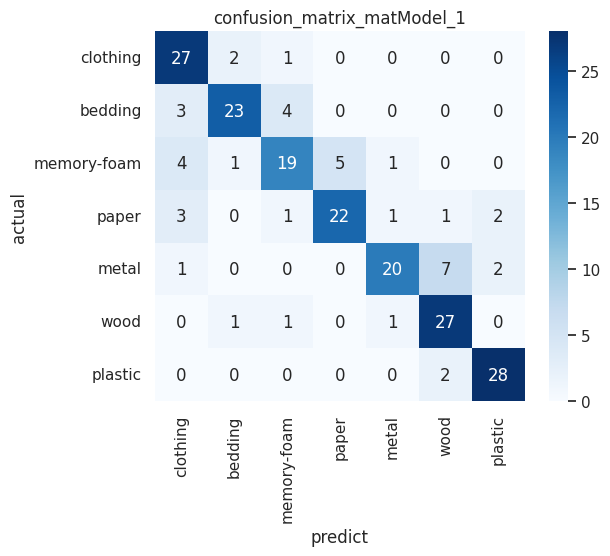

In [1016]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net2 = matModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.5) and epoch<max_epoch:
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net2.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net2(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net2.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net2(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_1'    
matModel_trained = net2
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,1,1)

print(report)



### object 1

In [1017]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 25

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-2.3811e+01, -1.9711e+01, -1.3184e+01,  ..., -9.4136e+00,
           -9.8433e+00, -1.2776e+01],
          [-2.3483e+01, -2.2420e+01, -1.7059e+01,  ..., -1.2228e+01,
           -1.6784e+01, -1.8620e+01],
          [-2.6552e+01, -2.5920e+01, -2.9190e+01,  ..., -2.5200e+01,
           -2.4904e+01, -2.9645e+01],
          ...,
          [-5.5713e+01, -5.2651e+01, -5.1864e+01,  ..., -5.2674e+01,
           -5.2471e+01, -5.4133e+01],
          [-5.4714e+01, -5.2765e+01, -5.3494e+01,  ..., -5.2972e+01,
           -5.2946e+01, -5.4094e+01],
          [-5.5056e+01, -5.1401e+01, -5.2169e+01,  ..., -5.2170e+01,
           -5.1594e+01, -5.4338e+01]]],


        [[[-1.5113e+01, -5.9229e+00, -5.4663e+00,  ..., -6.5937e+00,
           -1.1848e+01, -1.0728e+01],
          [-1.2987e+01, -7.5467e+00, -1.0063e+01,  ..., -6.1333e+00,
           -1.0914e+01, -9.3855e+00],
          [-1.7104e+01, -1.5642e+01, -1.5878e+01,  ..., -1.4834e+01,
           -1.4225e+01, -1.3567e+01],
          ...,
  

In [1018]:
# モデルのインポート・構築

objModel = matModel_trained

#パラメータの更新を許可
for param in objModel.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
objModel.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=527, bias=True),
    nn.BatchNorm1d(527),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=21, bias=True),  # 新しい層
)
print(objModel)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

cuda:0
Epoch [1/150], Train Loss: 2.0353, Validation Loss: 2.6960
Epoch [2/150], Train Loss: 0.9861, Validation Loss: 1.4700
Epoch [3/150], Train Loss: 0.5764, Validation Loss: 1.1441
Epoch [4/150], Train Loss: 0.3493, Validation Loss: 1.1324
Epoch [5/150], Train Loss: 0.2039, Validation Loss: 1.0090
Epoch [6/150], Train Loss: 0.1087, Validation Loss: 1.0627
Epoch [7/150], Train Loss: 0.0618, Validation Loss: 1.0452
Epoch [8/150], Train Loss: 0.0403, Validation Loss: 1.0247
Epoch [9/150], Train Loss: 0.0290, Validation Loss: 1.0679
Epoch [10/150], Train Loss: 0.0219, Validation Loss: 1.0750
Epoch [11/150], Train Loss: 0.0174, Validation Loss: 1.0888
Epoch [12/150], Train Loss: 0.0151, Validation Loss: 1.0952
Epoch [13/150], Train Loss: 0.0129, Validation Loss: 1.1142
Epoch [14/150], Train Loss: 0.0118, Validation Loss: 1.1033
Epoch [15/150], Train Loss: 0.0104, Validation Loss: 1.0942
Epoch [16/150], Train Loss: 0.0097, Validation Loss: 1.0988
Epoch [17/150], Train Loss: 0.0087, Valida

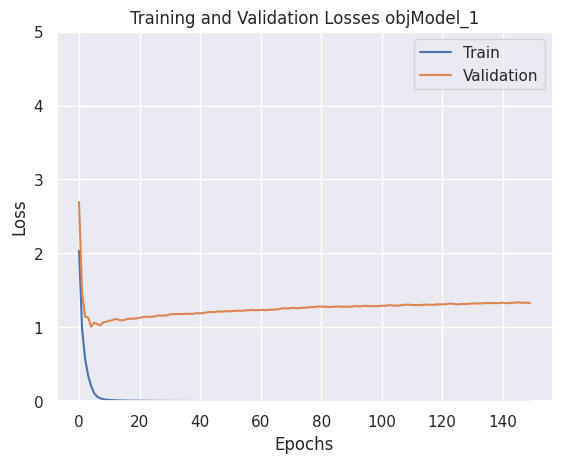

torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([25, 21])
torch.Size([10, 21])
               precision    recall  f1-score   support

      y-shirt      0.667     0.600     0.632        10
        jeans      0.467     0.700     0.560        10
   sweatshirt      0.375     0.300     0.333        10
      blanket      0.889     0.800     0.842        10
     bedquilt      0.636     0.700     0.667        10
       pillow      0.636     0.700     0.667        10
     mousepad      0.375     0.300     0.333        10
        chair      0.417     0.500     0.455        10
         sofa      0.900     0.900     0.900        10
   thick-Book      0.615     0.800     0.696        10
    thin-Book      0.600     0.300     0.400        10
    cardboard      0.556     0.500     0.526        10
   metal-desk      0.875     0.700     0.778        10
       laptop      1.000     0.800     0

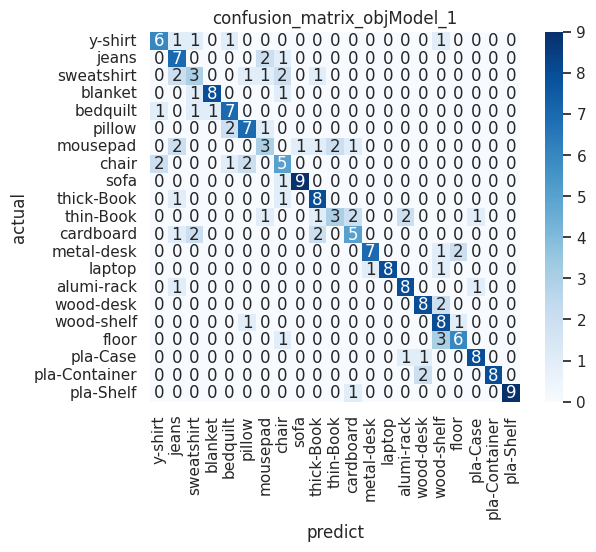

In [1019]:
# エポックの数
max_epoch = 150
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net3 = objModel.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net3.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net3.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net3(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net3.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net3(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_1'    
objModel_trained = net3
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, confidences = EvalCNN(test_loader,device,2,1)

print(report)


### soft-hard 2

In [1020]:
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [1021]:
shModel_2 = objModel_trained

#パラメータの更新を許可
for param in shModel_2.parameters():
    param.requires_grad = False


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
shModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.ReLU(),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.ReLU(),
    nn.Linear(in_features=21, out_features=2, bias=True),  # 新しい層  
    nn.Softmax(dim=1)
)
print(shModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

cuda:0
Epoch [1/100], Train Loss: 0.7296, Validation Loss: 1.1917
Epoch [2/100], Train Loss: 0.7099, Validation Loss: 1.2811
Epoch [3/100], Train Loss: 0.7054, Validation Loss: 1.3237
Epoch [4/100], Train Loss: 0.7041, Validation Loss: 1.3442
Epoch [5/100], Train Loss: 0.7036, Validation Loss: 1.3543
Epoch [6/100], Train Loss: 0.7035, Validation Loss: 1.3592
Epoch [7/100], Train Loss: 0.7034, Validation Loss: 1.3616
Epoch [8/100], Train Loss: 0.7034, Validation Loss: 1.3628
Epoch [9/100], Train Loss: 0.7034, Validation Loss: 1.3633
Epoch [10/100], Train Loss: 0.7033, Validation Loss: 1.3636
Epoch [11/100], Train Loss: 0.7033, Validation Loss: 1.3637
Epoch [12/100], Train Loss: 0.7033, Validation Loss: 1.3637
Epoch [13/100], Train Loss: 0.7032, Validation Loss: 1.3636
Epoch [14/100], Train Loss: 0.7031, Validation Loss: 1.3635
Epoch [15/100], Train Loss: 0.7031, Validation Loss: 1.3634
Epoch [16/100], Train Loss: 0.7030, Validation Loss: 1.3633
Epoch [17/100], Train Loss: 0.7029, Valida

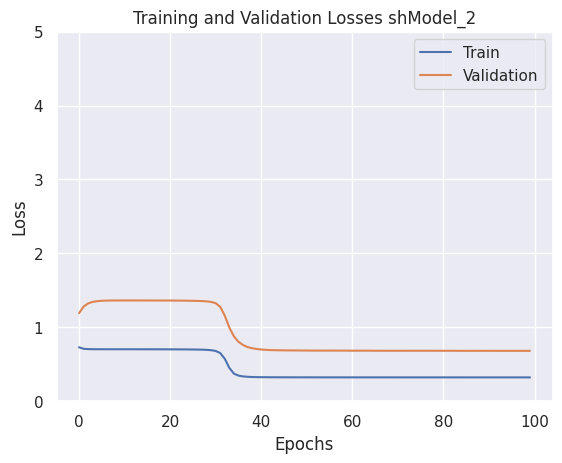

torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([25, 2])
torch.Size([10, 2])
              precision    recall  f1-score   support

        soft      0.906     0.967     0.935        90
        hard      0.974     0.925     0.949       120

    accuracy                          0.943       210
   macro avg      0.940     0.946     0.942       210
weighted avg      0.945     0.943     0.943       210



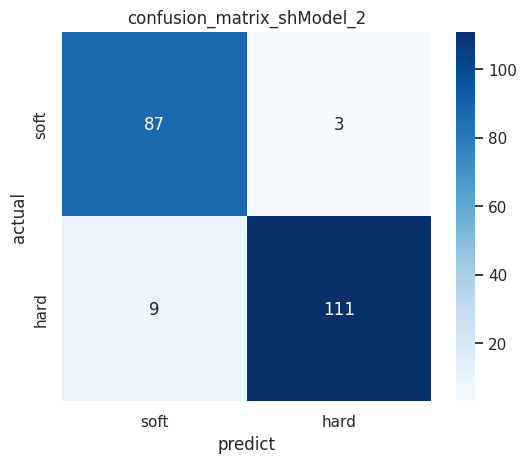

In [1022]:
# 学習と評価

# エポックの数
epoch = 0
max_epoch = 100
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net4 = shModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net4.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1
val_epoch_loss = 1
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.4) and epoch<max_epoch:
    # 訓練データでの学習
    net4.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)        
        t = t.to(device)
        optimizer.zero_grad()
        y = net4(x)
    
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net4.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net4(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1

model_name = 'shModel_2'    
shModel_trained = net4
SaveModel(shModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , shConfidences= EvalCNN(test_loader,device,0,2)

print(report)


### material 2

In [1023]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-23.8109, -19.7109, -13.1839,  ...,  -9.4136,  -9.8433, -12.7758],
          [-23.4827, -22.4204, -17.0588,  ..., -12.2277, -16.7844, -18.6201],
          [-26.5524, -25.9204, -29.1905,  ..., -25.2004, -24.9043, -29.6452],
          ...,
          [-55.7133, -52.6507, -51.8638,  ..., -52.6737, -52.4706, -54.1325],
          [-54.7137, -52.7646, -53.4942,  ..., -52.9719, -52.9461, -54.0942],
          [-55.0564, -51.4011, -52.1685,  ..., -52.1697, -51.5944, -54.3381]]],


        [[[-15.1125,  -5.9229,  -5.4663,  ...,  -6.5937, -11.8480, -10.7284],
          [-12.9873,  -7.5467, -10.0635,  ...,  -6.1333, -10.9136,  -9.3855],
          [-17.1038, -15.6422, -15.8783,  ..., -14.8341, -14.2252, -13.5668],
          ...,
          [-49.8661, -49.7012, -50.2227,  ..., -50.3835, -49.8694, -50.7761],
          [-52.2558, -50.1145, -49.4021,  ..., -51.2810, -49.7634, -50.8934],
          [-54.6858, -51.1991, -49.0457,  ..., -49.6776, -49.2134, -50.9535]]],


        [[[-21.2450, -11.

In [1024]:
matModel_2 = shModel_trained

#パラメータの更新を許可
for param in matModel_2.parameters():
    param.requires_grad = True


# print(model.classifier)

# 出力層の最後だけ変更
# model.classifier[5] = torch.nn.Linear(1280,2)
matModel_2.classifier= nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=88, out_features=7, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)
print(matModel_2)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

cuda:0
Epoch [1/200], Train Loss: 1.8127, Validation Loss: 1.9445
Epoch [2/200], Train Loss: 1.5782, Validation Loss: 1.9349
Epoch [3/200], Train Loss: 1.4323, Validation Loss: 1.9061
Epoch [4/200], Train Loss: 1.3591, Validation Loss: 1.8040
Epoch [5/200], Train Loss: 1.3108, Validation Loss: 1.6137
Epoch [6/200], Train Loss: 1.2819, Validation Loss: 1.4912
Epoch [7/200], Train Loss: 1.2579, Validation Loss: 1.4530
Epoch [8/200], Train Loss: 1.2342, Validation Loss: 1.4518
Epoch [9/200], Train Loss: 1.2221, Validation Loss: 1.4469
Epoch [10/200], Train Loss: 1.2042, Validation Loss: 1.4271
Epoch [11/200], Train Loss: 1.1968, Validation Loss: 1.4089
Epoch [12/200], Train Loss: 1.1900, Validation Loss: 1.4148
Epoch [13/200], Train Loss: 1.1858, Validation Loss: 1.3934
Epoch [14/200], Train Loss: 1.1827, Validation Loss: 1.3925
Epoch [15/200], Train Loss: 1.1816, Validation Loss: 1.3957
Epoch [16/200], Train Loss: 1.1801, Validation Loss: 1.3834
Epoch [17/200], Train Loss: 1.1786, Valida

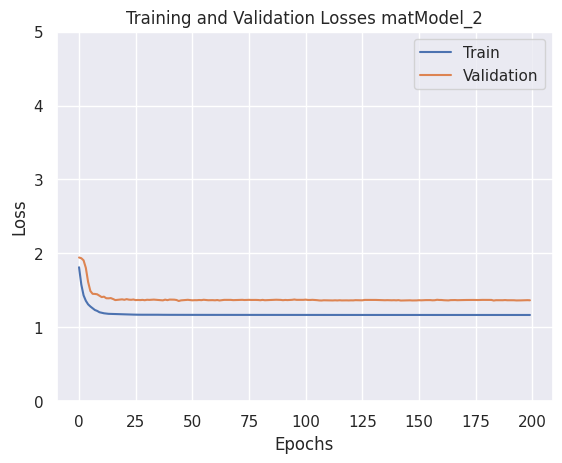

torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([50, 7])
torch.Size([10, 7])
              precision    recall  f1-score   support

    clothing      0.733     0.733     0.733        30
     bedding      0.818     0.900     0.857        30
 memory-foam      0.731     0.633     0.679        30
       paper      0.815     0.733     0.772        30
       metal      0.793     0.767     0.780        30
        wood      0.757     0.933     0.836        30
     plastic      1.000     0.933     0.966        30

    accuracy                          0.805       210
   macro avg      0.807     0.805     0.803       210
weighted avg      0.807     0.805     0.803       210



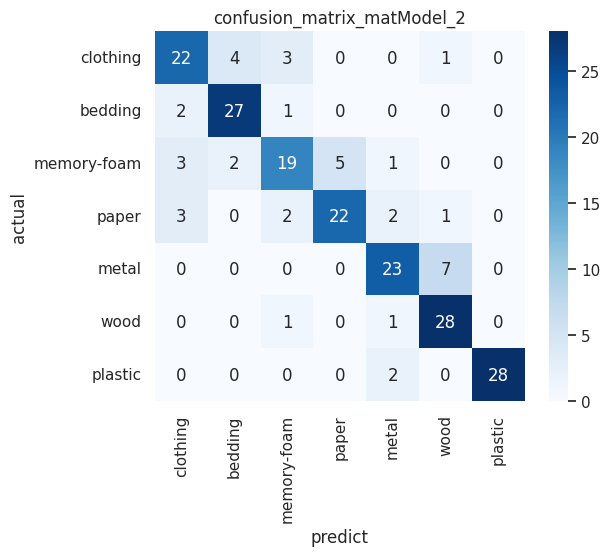

In [1025]:
#学習と評価
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# エポックの数
epoch = 0
max_epoch = 200
min_epoch = 100
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net5 = matModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net5.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

train_epoch_loss = 1.0
val_epoch_loss = 1.0
# 学習ループ
while (train_epoch_loss > 0.1 or val_epoch_loss  > 0.2) and epoch<max_epoch :
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net5.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net5(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net5.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net5(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')
    epoch+=1



model_name = 'matModel_2'    
matModel_trained = net5
SaveModel(matModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report, matConfidences = EvalCNN(test_loader,device,1,2)

print(report)



### object 2

In [1026]:
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

for batch in train_loader:
    print(batch)

[tensor([[[[-23.8109, -19.7109, -13.1839,  ...,  -9.4136,  -9.8433, -12.7758],
          [-23.4827, -22.4204, -17.0588,  ..., -12.2277, -16.7844, -18.6201],
          [-26.5524, -25.9204, -29.1905,  ..., -25.2004, -24.9043, -29.6452],
          ...,
          [-55.7133, -52.6507, -51.8638,  ..., -52.6737, -52.4706, -54.1325],
          [-54.7137, -52.7646, -53.4942,  ..., -52.9719, -52.9461, -54.0942],
          [-55.0564, -51.4011, -52.1685,  ..., -52.1697, -51.5944, -54.3381]]],


        [[[-15.1125,  -5.9229,  -5.4663,  ...,  -6.5937, -11.8480, -10.7284],
          [-12.9873,  -7.5467, -10.0635,  ...,  -6.1333, -10.9136,  -9.3855],
          [-17.1038, -15.6422, -15.8783,  ..., -14.8341, -14.2252, -13.5668],
          ...,
          [-49.8661, -49.7012, -50.2227,  ..., -50.3835, -49.8694, -50.7761],
          [-52.2558, -50.1145, -49.4021,  ..., -51.2810, -49.7634, -50.8934],
          [-54.6858, -51.1991, -49.0457,  ..., -49.6776, -49.2134, -50.9535]]],


        [[[-21.2450, -11.

In [1027]:
objModel_2 = matModel_trained

# パラメータの更新を許可
for param in objModel_2.parameters():
    param.requires_grad =  True

# 新しい層の追加とBatch Normalizationの導入
objModel_2.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=960, out_features=1280, bias=False),
    nn.Hardswish(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1280, out_features=527, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=527, out_features=176, bias=True),  # 新しい層
    nn.BatchNorm1d(176),
    nn.ReLU(),
    nn.Linear(in_features=176, out_features=88, bias=True),  # 新しい層
    nn.BatchNorm1d(88),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=88, out_features=21, bias=True),  # 新しい層  
    nn.Softmax(dim=1)

)

print(objModel_2)


DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

cuda:0
Epoch [1/500], Train Loss: 3.0395, Validation Loss: 3.0445
Epoch [2/500], Train Loss: 3.0276, Validation Loss: 3.0439
Epoch [3/500], Train Loss: 2.9989, Validation Loss: 3.0411
Epoch [4/500], Train Loss: 2.9746, Validation Loss: 3.0278
Epoch [5/500], Train Loss: 2.9439, Validation Loss: 2.9899
Epoch [6/500], Train Loss: 2.9182, Validation Loss: 2.9348
Epoch [7/500], Train Loss: 2.8844, Validation Loss: 2.9080
Epoch [8/500], Train Loss: 2.8571, Validation Loss: 2.8602
Epoch [9/500], Train Loss: 2.8399, Validation Loss: 2.8515
Epoch [10/500], Train Loss: 2.8052, Validation Loss: 2.8028
Epoch [11/500], Train Loss: 2.7753, Validation Loss: 2.8087
Epoch [12/500], Train Loss: 2.7534, Validation Loss: 2.7953
Epoch [13/500], Train Loss: 2.7205, Validation Loss: 2.7578
Epoch [14/500], Train Loss: 2.7062, Validation Loss: 2.7535
Epoch [15/500], Train Loss: 2.6818, Validation Loss: 2.7322
Epoch [16/500], Train Loss: 2.6720, Validation Loss: 2.7190
Epoch [17/500], Train Loss: 2.6347, Valida

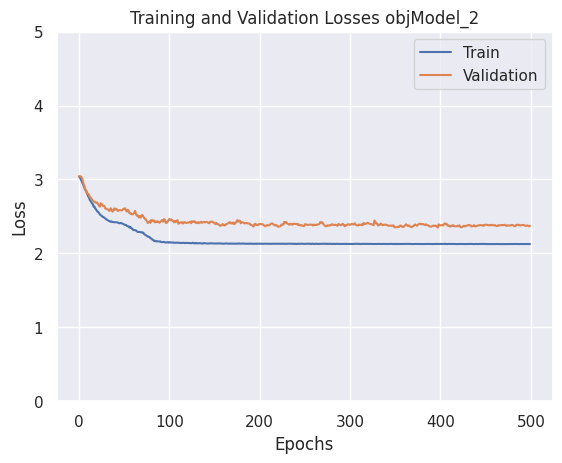

torch.Size([50, 21])
torch.Size([50, 21])
torch.Size([50, 21])
torch.Size([50, 21])
torch.Size([10, 21])
               precision    recall  f1-score   support

      y-shirt      0.875     0.700     0.778        10
        jeans      0.700     0.700     0.700        10
   sweatshirt      0.444     0.400     0.421        10
      blanket      0.889     0.800     0.842        10
     bedquilt      0.900     0.900     0.900        10
       pillow      0.769     1.000     0.870        10
     mousepad      0.600     0.600     0.600        10
        chair      0.625     0.500     0.556        10
         sofa      1.000     0.900     0.947        10
   thick-Book      1.000     0.700     0.824        10
    thin-Book      0.462     0.600     0.522        10
    cardboard      0.700     0.700     0.700        10
   metal-desk      0.667     0.600     0.632        10
       laptop      1.000     0.800     0.889        10
   alumi-rack      0.529     0.900     0.667        10
    wood-desk 

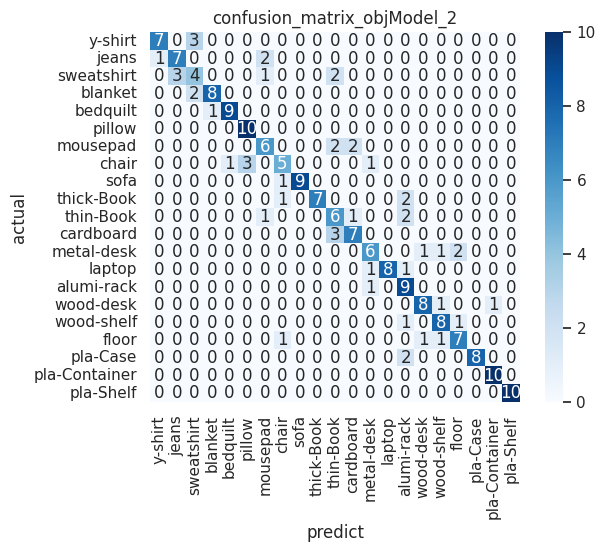

In [1028]:
# エポックの数
max_epoch = 500
     
# モデルの初期化
torch.manual_seed(0)

# GPU の設定状況に基づいたデバイスの選択
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# モデルのインスタンス化とデバイスへの転送
net6 = objModel_2.cuda()

criterion = F.cross_entropy
  
# 最適化手法の選択
optimizer = torch.optim.SGD(net6.parameters(), lr=0.1)
# エポックごとの訓練データの損失と検証データの損失を保存するリスト
train_losses = []
val_losses = []

# 学習ループ
for epoch in range(max_epoch):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0
    
    # 訓練データでの学習
    net6.train()
    for batch in train_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        optimizer.zero_grad()
        y = net6(x)
        loss = criterion(y[0], t)
        train_epoch_loss += loss.item()  # エポック全体の訓練データの損失に加算
        loss.backward()
        optimizer.step()
    
    # 訓練データでのエポックごとの平均損失を計算し保存
    train_epoch_loss /= len(train_loader)
    train_losses.append(train_epoch_loss)
    
    # 検証データでの評価
    net6.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, t = batch
  
            x = x.to(device)
            t = t.to(device)
            y = net6(x)
            loss = criterion(y[0], t)
            val_epoch_loss += loss.item()  # エポック全体の検証データの損失に加算
       
    # 検証データでのエポックごとの平均損失を計算し保存
    val_epoch_loss /= len(val_loader)
    val_losses.append(val_epoch_loss)
    
    # エポックごとに損失を表示
    print(f'Epoch [{epoch+1}/{max_epoch}], Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}')



model_name = 'objModel_2'    
objModel_trained = net6
SaveModel(objModel_trained,model_name)

title = 'Training and Validation Losses '+model_name
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.savefig('data/models_saved/'+Time()+'_'+model_name+'_losses.pdf')

plt.show()


# テストデータで確認
preds , actuals, report , objConfidences= EvalCNN(test_loader,device,2,2)

print(report)


## DPSWS 評価

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

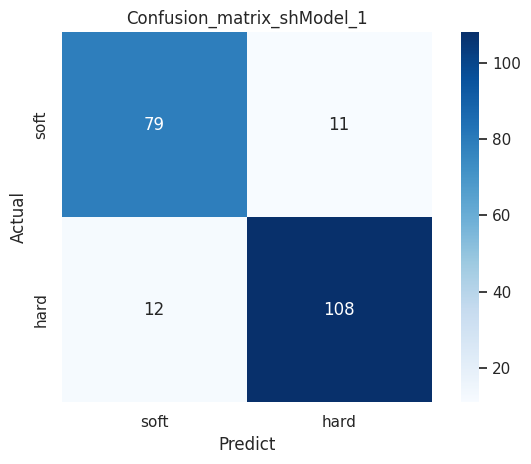

In [1383]:
model_path = 'data/models_saved/202406302320_shModel_1.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,1,shModel_eval)
print(shReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

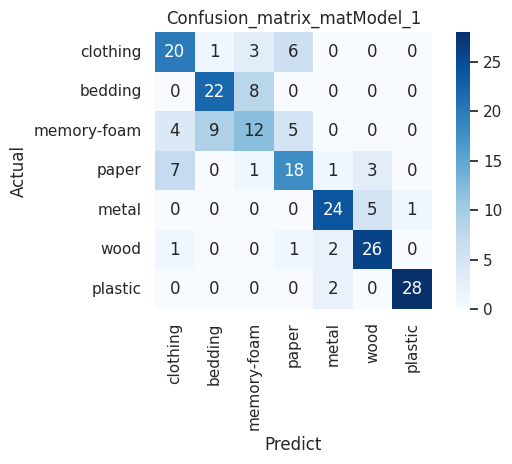

In [1384]:
model_path = 'data/models_saved/202406302324_matModel_1.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,1,matModel_eval)
print(matReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

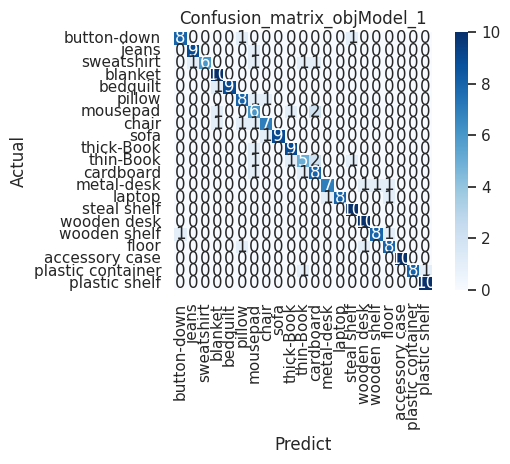

In [1385]:
model_path = 'data/models_saved/202406302328_objModel_1.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)

#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,1,objModel_eval)
print(objReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

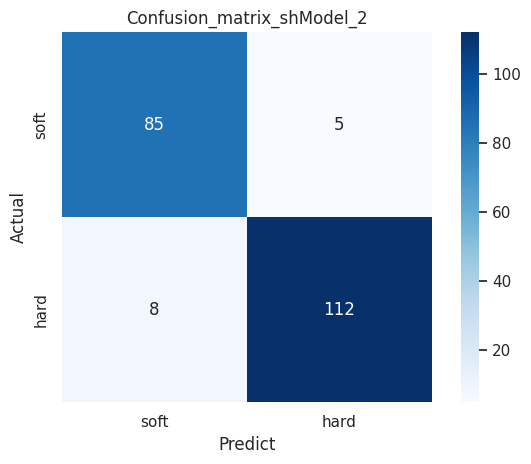

In [1386]:
model_path = 'data/models_saved/202406302329_shModel_2.pth'
shModel_eval = torch.load(model_path)
print(shModel_eval)
#データセットの選択・データローダに読み込む
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()
# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(2)

# tensorDatasetの作成
label_num = 2
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

batch_size = 25 # バッチサイズ

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)
shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,2,shModel_eval)
print(shReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

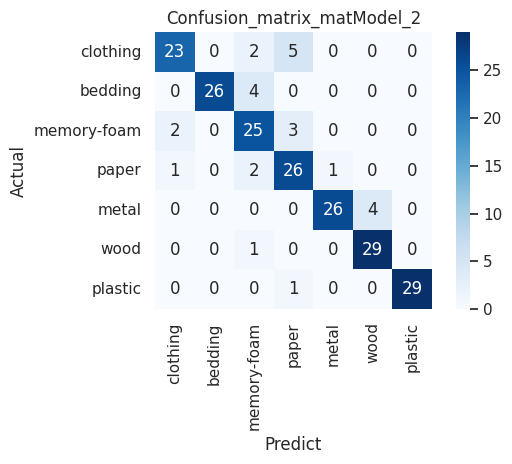

In [1387]:
model_path = 'data/models_saved/202406302329_matModel_2.pth'
matModel_eval = torch.load(model_path)
print(matModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 1
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,2,matModel_eval)
print(matReport)

DyMN(
  (layers): ModuleList(
    (0): DY_Block(
      (exp_conv): DynamicWrapper(
        (module): Identity()
      )
      (exp_norm): Identity()
      (exp_act): DynamicWrapper(
        (module): Identity()
      )
      (depth_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (depth_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (depth_act): DyReLUB(
        (coef_net): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
        )
        (sigmoid): Sigmoid()
      )
      (ca): CoordAtt()
      (proj_conv): DynamicConv(
        (residuals): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
        )
      )
      (proj_norm): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (context_gen): ContextGen(
        (joint_conv): Conv2d(16, 32, kernel_size=(1, 1

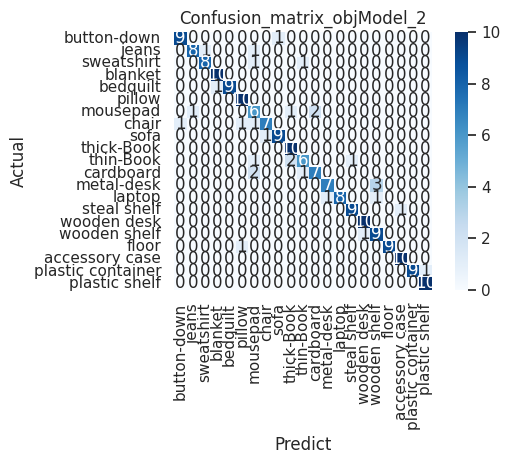

In [1388]:
model_path = 'data/models_saved/202406302343_objModel_2.pth'
objModel_eval = torch.load(model_path)
print(objModel_eval)
#データセットの選択・データローダに読み込む

# train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Make_other_dataset(0)
train_feature,train_labels, val_feature, val_labels,test_feature,test_labels = Alldataset()

# tensorDatasetの作成
label_num = 0
train = torch.utils.data.TensorDataset(train_feature, train_labels[:,label_num])
val = torch.utils.data.TensorDataset(val_feature, val_labels[:,label_num])
test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])

# データローダに読み込む

# バッチサイズ
batch_size = 50

# shuffle はデフォルトで False のため、学習データのみ True に指定
train_loader = torch.utils.data.DataLoader(train, batch_size)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)
print(objReport)

### 提案手法適用時の評価

In [1374]:
# print(shConfidences)
# print(matConfidences)
# print(objConfidences[100])

In [1333]:
# array = objConfidences[100]
# exp_array = np.exp(array)
# # exp_array = array
# softmax_array = np.round((exp_array / np.sum(exp_array, axis=0, keepdims=True)),3)

# print(softmax_array)

In [1334]:
def Hiera_report(confidences,label,preds,actuals):
    array = np.array(confidences)
    print(array.shape)
    # 行ごとにSoftmax関数を適用
    # exp_array = np.exp(array)
    # softmax_array = np.round((exp_array / np.sum(exp_array, axis=1, keepdims=True)),3)

    # print(softmax_array)

    # df = pd.DataFrame(softmax_array,columns = label)
    df = pd.DataFrame(array,columns = label)
    # df["decision"] = np.max(Dec, axis=1)
    df["prediction"] = np.array(preds)
    df['Actual'] = np.array(actuals)
    # df["decision"] = np.max(softmax_array, axis=1)
    df["decision"] = np.max(array, axis=1)
    pd.set_option('display.max_rows',100)
    pd.set_option('display.max_columns',None)


    len_df = len(df.index)

    return df , len_df

In [1335]:
# array = [0.3,0.3,0.4,0.2]
# exp_array = np.exp(array)
# softmax_array = np.round((exp_array / np.sum(exp_array, axis=1, keepdims=True)),3)

In [1336]:
df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_object = filtered_rows['decision'].mean()
# average_decision_object = 17


print(df)
print("平均 decision:", average_decision_object)
# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# 閾値以上を抽出しDFを作成
up_data = df[df['decision'] >= average_decision_object]


print(classification_report(up_data['Actual'], up_data['prediction'],digits=3))

print("採用数:", len(up_data.index))
print("採用率:", len(up_data.index)/len_df)
# 閾値未満を抽出しDFを作成
down_data = df[df['decision'] < average_decision_object]

print("不採用数:",down_data.shape[0])
    

(210, 21)
      y-shirt     jeans  sweatshirt    blanket  bedquilt     pillow  mousepad  \
0    2.411845 -0.122896   -0.606207  -4.324915 -2.231772  -1.388398  3.397088   
1   -0.270852 -4.971002    2.988255  22.919485  3.318503   0.815073 -0.417611   
2    1.328981 -1.642048   -3.054834   0.114375 -3.093427   1.201046 -5.479822   
3   -1.223480 -1.488337   -1.817849   0.989899  0.883177   7.597976  2.476688   
4    1.706369  0.148786   -0.397034  -4.134669 -1.725217  -0.919322  2.085314   
..        ...       ...         ...        ...       ...        ...       ...   
205 -0.031610  3.856924   15.150069   1.397447  2.386186  -3.357179  2.292061   
206 -0.975848 -0.546382   -4.872843   3.455078  3.627404  19.020523  1.686713   
207 -0.148464 -4.613915    3.354406  22.582739  2.897032   0.639272 -0.924271   
208  0.688085  3.506310   16.732199   4.020337  2.307122  -3.875430 -0.860898   
209 -1.500587 -1.656864   -2.351560   0.918359  2.606304   1.787088 -3.335902   

        chair    

In [1337]:
print(matLabel)

['clothing', 'bedding', 'memory-foam', 'paper', 'metal', 'wood', 'plastic']


In [1390]:
df,len_df = Hiera_report(matConfidences,matLabel,matPreds,matActuals)

# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_material = filtered_rows['decision'].mean()


print("平均 decision:", average_decision_material)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[down_data.index]

Up_material = df[df['decision'] >= average_decision_material]


print(classification_report(Up_material['Actual'], Up_material['prediction'],digits=3))

print("採用数:", len(Up_material.index))
print("採用率:", len(Up_material.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_material = df[df['decision'] < average_decision_material]

print("不採用:",Down_material.shape[0])

print(Down_material)

(210, 7)
平均 decision: 3.580045
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3
           2      1.000     1.000     1.000         1
           3      1.000     1.000     1.000         3
           4      1.000     1.000     1.000         5
           5      1.000     1.000     1.000         7
           6      1.000     1.000     1.000         4

    accuracy                          1.000        26
   macro avg      1.000     1.000     1.000        26
weighted avg      1.000     1.000     1.000        26

採用数: 26
採用率: 0.12380952380952381
不採用: 24
    clothing   bedding  memory-foam     paper     metal      wood   plastic  \
3   0.406641  0.038004     1.243042 -0.654465 -1.120538  0.571168 -0.782904   
7  -1.218065 -1.006331    -1.050484  0.094344  3.046897  0.486336 -0.724970   
8  -0.305289  2.753593     1.106457 -0.874465 -0.833014 -0.855815 -0.781258   
10 -1.032739 -0

In [1389]:
df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
# 平均を算出し、物体レベルの閾値を決定する

# predictionとActualが同じ場合の行を抽出
filtered_rows = df[df['prediction'] == df['Actual']]

# decision列の平均を計算
average_decision_softhard = filtered_rows['decision'].mean()

print("平均 decision:", average_decision_softhard)

# 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
# 閾値以上を抽出しDFを作成
df = df.iloc[Down_material.index]
Up_softhard = df[df['decision'] >= average_decision_softhard]


print(classification_report(Up_softhard['Actual'], Up_softhard['prediction'],digits=3))

print("採用数:", len(Up_softhard.index))
print("採用率:", len(Up_softhard.index)/len_df)

# 閾値未満を抽出しDFを作成
Down_softhard = df[df['decision'] < average_decision_softhard]

print("不採用:",Down_softhard.shape[0])


(210, 2)
平均 decision: 2.7275383
        soft      hard  prediction  Actual  decision
7  -2.744195  2.886573           1       1  2.886573
20  4.571621 -5.020974           0       0  4.571621
28 -2.671204  2.810003           1       1  2.810003
29  3.420997 -3.773355           0       0  3.420997
38  4.571581 -5.020229           0       0  4.571581
47 -2.714411  2.854886           1       1  2.854886
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6

採用数: 6
採用率: 0.02857142857142857
不採用: 9


In [1340]:


df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)


Down_all = df.iloc[Down_softhard.index]


print(classification_report(Down_all['Actual'], Down_all['prediction'],digits=3))


(210, 2)
              precision    recall  f1-score   support

           0      0.795     0.886     0.838        35
           1      0.800     0.667     0.727        24

    accuracy                          0.797        59
   macro avg      0.797     0.776     0.783        59
weighted avg      0.797     0.797     0.793        59



### 組み合わせた時の評価

In [1341]:
# 正解率の計算
# def EvalCNN(data_loader, model, label,modelname,device):
def EvalCNN_trained(data_loader,device,num_label,num_trial,model):
    with torch.no_grad():
        if num_label == 0:
            label = shLabel
            label_num = shNum
            model_name = "shModel_"+str(num_trial)
        elif num_label == 1:
            label = matLabel
            label_num = matNum
            model_name = "matModel_"+str(num_trial)
        elif num_label == 2:
            label = objLabel
            label_num = objNum
            model_name = "objModel_"+str(num_trial)

        preds = []
        actuals = []
        confidences = []
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            # print(y[0])
            pred = torch.argmax(y[0], dim=1)
            confidence = y[0]
            confidences.extend(confidence.cpu().numpy())
            # preds.append(pred)
            preds.extend(pred.cpu().numpy())
            actuals.extend(t.cpu().numpy())
            # print(preds.shape,actuals.shape)
        report_out = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num)
        report = classification_report(actuals, preds,digits=3,target_names=label,labels=label_num,output_dict=True)
        report_df = pd.DataFrame(report).T
        time = Time()


        report_df.to_csv('data/models_saved/'+time+'_'+model_name+'_report.csv')

        # #混同行列の作成
        # cm = confusion_matrix(y_true=actuals,y_pred=preds,labels=label_num)
        # p = sns.heatmap(cm, square=True, cbar=True, annot=True,cmap='Blues',fmt="d",
        #                 xticklabels=label,
        #                 yticklabels=label)
        # title = "confusion_matrix_"+model_name
        # plt.title(title)
        # plt.xlabel('predict')
        # plt.ylabel('actual')
        # plt.savefig('data/models_saved/'+time+'_'+model_name+'_cm.pdf')
            
    return preds, actuals,report_out,confidences

In [1342]:
# eval_num = 0
# print(eval_num)
# start = eval_num*trials
# end = (eval_num+1)*trials

# test_feature = Dataset_melspec_tensor[start:end,:,:,:]
# test_labels = Dataset_label_tensor[start:end,:]


# # obj--------------------

# # tensorDatasetの作成
# label_num = 0

# test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
# # データローダに読み込む

# batch_size = 25 # バッチサイズ

# test_loader = torch.utils.data.DataLoader(test, batch_size)

# model_path = 'data/models_saved/objModel_2_'+str(eval_num)+'.pth'
# objModel_eval = torch.load(model_path)
# objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)

# print(objConfidences)
# df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

# print(df)

# # decision列の平均を計算

# a = average_decision_object 
# # a = 1
# print("平均 decision:", a)
# # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

# # 閾値以上を抽出しDFを作成
# up_data = df[df['decision'] >= a]

# # print("f1_score:",f1_score(up_data['Actual'], up_data['prediction'],average='weighted'))
# obj_pick = len(up_data.index)

# print("採用数:", obj_pick)
# print("採用率:", len(up_data.index)/len_df)
# # 閾値未満を抽出しDFを作成
# down_data = df[df['decision'] < a]

# print("不採用数:",down_data.shape[0])

In [1343]:
df_hiera = pd.DataFrame()

for eval_num in range(21):
    print(eval_num)
    start = eval_num*trials
    end = (eval_num+1)*trials

    test_feature = Dataset_melspec_tensor[start:end,:,:,:]
    test_labels = Dataset_label_tensor[start:end,:]
    print(test_labels.shape)


    # obj--------------------

    # tensorDatasetの作成
    label_num = 0

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/objModel_2_'+str(eval_num)+'.pth'
    objModel_eval = torch.load(model_path)
    objPreds , objActuals, objReport , objConfidences = EvalCNN_trained(test_loader,device,2,2,objModel_eval)

    df,len_df = Hiera_report(objConfidences,objLabel,objPreds,objActuals)

    # decision列の平均を計算

    a = average_decision_object 
    # a = 17
    print("平均 decision:", a)
    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成

    # 閾値以上を抽出しDFを作成
    up_data = df[df['decision'] >= a]

    # print("f1_score:",f1_score(up_data['Actual'], up_data['prediction'],average='weighted'))
    obj_pick = len(up_data.index)

    print("採用数:", obj_pick)
    print("採用率:", len(up_data.index)/len_df)
    # 閾値未満を抽出しDFを作成
    down_data = df[df['decision'] < a]

    print("不採用数:",down_data.shape[0])


    # mat------------------

    label_num = 1

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/matModel_2_'+str(eval_num)+'.pth'
    matModel_eval = torch.load(model_path)
    matPreds , matActuals, matReport , matConfidences = EvalCNN_trained(test_loader,device,1,2,matModel_eval)

    df,len_df = Hiera_report(matConfidences,matLabel,matPreds,matActuals)

    print(df)

    b = average_decision_material
    # b = 2.7
    print("平均 decision:", b)

    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
    # 閾値以上を抽出しDFを作成
    df = df.iloc[down_data.index]

    Up_material = df[df['decision'] >= b]

    f1_mat = f1_score(Up_material['Actual'], Up_material['prediction'],average='weighted')
    print("f1_score:",f1_mat)

    mat_pick = len(Up_material.index)
    print("採用数:", mat_pick)
    print("採用率:", len(Up_material.index)/len_df)

    # 閾値未満を抽出しDFを作成
    Down_material = df[df['decision'] < b]

    print("不採用:",Down_material.shape[0])


    # sh------------------


    label_num = 2

    test = torch.utils.data.TensorDataset(test_feature, test_labels[:,label_num])
    # データローダに読み込む

    batch_size = 25 # バッチサイズ

    test_loader = torch.utils.data.DataLoader(test, batch_size)

    model_path = 'data/models_saved/shModel_2_'+str(eval_num)+'.pth'
    shModel_eval = torch.load(model_path)
    shPreds , shActuals, shReport , shConfidences = EvalCNN_trained(test_loader,device,0,2,shModel_eval)

    df,len_df = Hiera_report(shConfidences,shLabel,shPreds,shActuals)
    c =  average_decision_softhard
    # c = 2
    print("平均 decision:",c)
    # 算出した推定確信度で閾値を超えていたら、超えているもので推定結果をだす、超えていないものでDFを作成
    # 閾値以上を抽出しDFを作成
    df = df.iloc[Down_material.index]
    Up_softhard = df[df['decision'] >= c]

    f1_sh = f1_score(Up_softhard['Actual'], Up_softhard['prediction'],average='weighted')
    print("f1_score:",f1_sh)

    sh_pick = len(Up_softhard.index)
    print("採用数:", sh_pick)
    print("採用率:", len(Up_softhard.index)/len_df)

    # 閾値未満を抽出しDFを作成
    Down_softhard = df[df['decision'] < c]

    print("不採用:",Down_softhard.shape[0])

    # 新しい行のデータをリストまたはDataFrameとして準備
    new_rows = [obj_pick, mat_pick, f1_mat, sh_pick, f1_sh]

    # concat() を使用して新しい行を追加
    df_hiera = pd.concat([df_hiera, pd.DataFrame([new_rows])],ignore_index=True)
# df_hiera = df_hiera.rename(columns={'obj_pick','mat_pick','f1_mat','sh_pick','f1_sh'})

0
torch.Size([50, 3])
(50, 21)
平均 decision: 17.97886
採用数: 0
採用率: 0.0
不採用数: 50
(50, 7)
    clothing   bedding  memory-foam     paper     metal      wood   plastic  \
0  -0.541838  2.452364     0.695385 -0.601831 -0.391677 -0.880500 -0.655623   
1   2.207358 -0.748085     0.878197 -0.178092 -0.491530 -0.523776 -0.808893   
2  -0.725831  2.814282     0.592693 -0.566030 -0.371425 -1.000455 -0.649396   
3   0.838533 -0.202324     2.482806 -0.670907 -0.629491 -0.685959 -1.074503   
4   0.272159 -0.185186     2.408343 -0.431758 -0.431129 -0.666722 -0.839777   
5   1.840281 -0.607148     1.162601 -0.389854 -0.477287 -0.416966 -0.776226   
6   0.426861  1.060507     1.065097 -0.473786 -0.396637 -0.609074 -0.755466   
7   2.649708 -0.728693     0.718900 -0.284410 -0.594723 -0.565698 -0.784213   
8   0.946131 -0.788618     1.117446  0.477831 -0.215886 -0.635710 -0.743173   
9   1.592075 -0.628985     1.628177 -0.413824 -0.453653 -0.520956 -0.937116   
10  2.168859 -0.840777    -0.305995  0.357472

In [1345]:
df_hiera.round(3)

,0,1,2,3,4
0,0,1,0.000,1,1.0
1,3,8,0.857,8,1.0
2,2,0,NaN,6,1.0
3,12,15,0.000,7,1.0
4,6,34,0.938,5,1.0
5,1,0,NaN,12,1.0
6,1,1,0.000,0,NaN
7,1,46,0.606,0,NaN
8,4,41,0.845,1,1.0
9,0,18,0.105,2,0.0
